# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: <mark>PABLO RAMBLADO CARRASCO</mark>



<font color='#ADD8E6'>El objetivo de esta práctica es aprender a diseñar, implementar, entrenar y utilizar (es decir, aplicar en inferencia) redes neuronales convolucionales en tareas de visión por computador (clasificación y regresión en imágenes) usando fastai (https://docs.fast.ai/).

<font color='#ADD8E6'>Se proporciona una guía de ayuda (`Assignment_2_HG.ipynb`) para, entre otras cosas, saber cómo:
1. realizar funciones básicas de lectura de datos, entrenamiento y optimización;
2. crear gráficos para la evolución del error de clasificación en
los conjuntos de entrenamiento y validación;
3. y calcular el error de clasificación en el conjunto de prueba.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='#ADD8E6'>**Ejercicio 1: BaseNet en CIFAR100 (3 puntos)**

<font color='#ADD8E6'>**Dataset:**
En este ejercicio, trabajaremos con parte del conjunto de datos CIFAR100 (https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto de datos consta de $60000$ imágenes en color de $32\times32\times3$ (RGB) que representan 100 clases diferentes ($600$ imágenes por clase). Hay $50000$ imágenes para entrenamiento y $10000$ para test. No obstante, para el desarrollo del ejercicio solo consideraremos $25$ clases (de $100$). Por lo tanto, el conjunto de entrenamiento tendrá $12500$ imágenes y el conjunto de prueba $2500$ imágenes. Los alumnos deben emplear el $10\%$ del conjunto de entrenamiento para  validación.

<font color='#ADD8E6'>**Modelo BaseNet:**
Comenzamos creando un modelo base llamado *BaseNet* que consta de dos bloques convolucionales (Conv+ReLU) separados por un proceso de *subsampling* (MaxPooling), y una cabeza compuesta por dos capas completamente conectadas (FC) (también llamadas capas densas). La arquitectura precisa se define en la siguiente tabla:

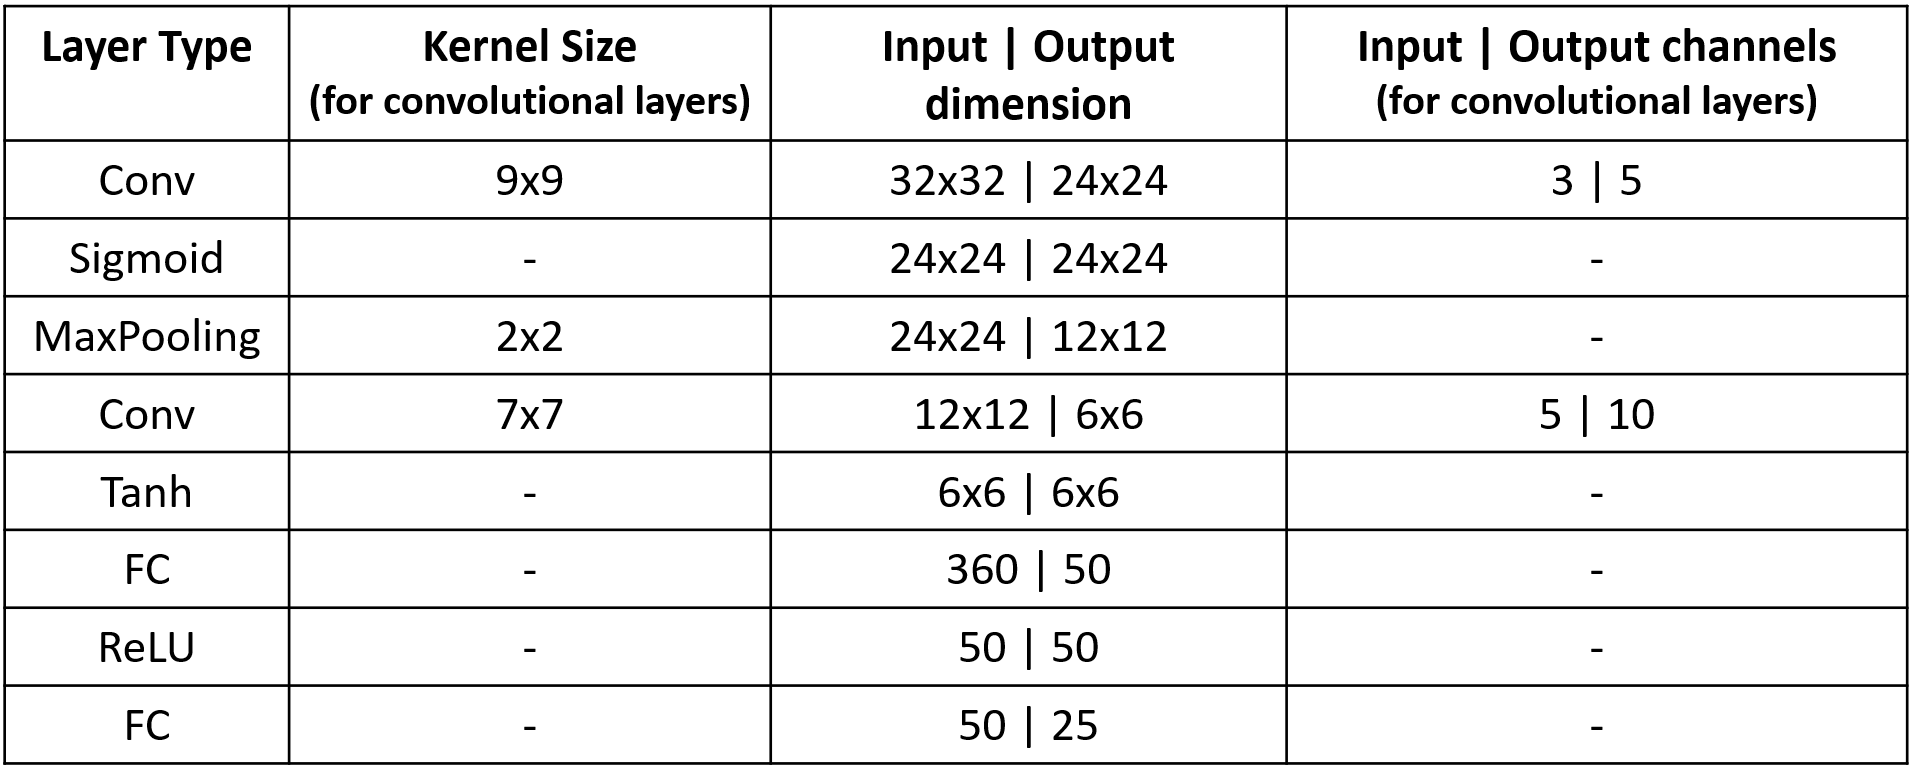

<font color='#ADD8E6'>Los alumnos deben:
1. Crear el código para el modelo *BaseNet* empleando la librería fastai.
2. Explicar y describir cada una de las capas de la arquitectura *BaseNet*, así como las decisiones de implementación tomadas. Por ejemplo, ¿qué función de pérdida se debería emplear: `CrossEntropyLoss()`, `CrossEntropyLossFlat()` o alguna otra? ¿Se debería incorporar manualmente, en la definición de la red, la función de activación de la capa final (`nn.Softmax()`)? ¿Por qué?
3. Desglosar detalladamente el número de parámetros de esta arquitectura, y cuánto contribuye cada capa a dicho número total. Se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido adecuadamente y que el número de parámetros es correcto (es decir, se corresponde con lo esperado).
4. Entrenar el modelo con _Adam_ (incluyendo _early stopping_ con una paciencia de $5$ durante $25$ épocas) y evaluar su rendimiento. En dicha evaluación se debe emplear/mostrar/analizar: la matriz de confusión en entrenamiento, validación y test; la _accuracy_ en entrenamiento, validación y test; y la evolución, por épocas de entrenamiento, tanto de la función de pérdida (en entrenamiento y validación) como de la _accuracy_ (en validación) y el _F1 score (weighted)_ (en validación).



In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/test'), Path('/root/.fastai/data/cifar100/train')]
[Path('/root/.fastai/data/cifar100/train/reptiles'), Path('/root/.fastai/data/cifar100/train/household_furniture'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores'), Path('/root/.fastai/data/cifar100/train/vehicles_1'), Path('/root/.fastai/data/cifar100/train/food_containers'), Path('/root/.fastai/data/cifar100/train/vehicles_2'), Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/flowers'), Path('/root/.fastai/data/cifar100/train/household_electrical_devices'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/trees'), Path('/

Vemos que hay 20 clases, pero eso no debe confundirnos. Eso son solo las 20 superclases en que está subdividido el dataset. Véase https://github.com/fastai/dlcert2/blob/master/docs/datasets.md:
"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. **The 100 classes in the CIFAR-100 are grouped into 20 superclasses**. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)."

In [ ]:
# Queremos verificar que dentro de cada una de las 20 superclases hay 5 clases,
# lo que da las 100 clases que hay. También queremos verificar que el número de imágenes
# es correcto
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Número de clases dentro de superclase ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/reptiles ):  [Path('/root/.fastai/data/cifar100/train/reptiles/dinosaur'), Path('/root/.fastai/data/cifar100/train/reptiles/turtle'), Path('/root/.fastai/data/cifar100/train/reptiles/snake'), Path('/root/.fastai/data/cifar100/train/reptiles/lizard'), Path('/root/.fastai/data/cifar100/train/reptiles/crocodile')]
Número de clases dentro de superclase  0 :  5
Número de clases dentro de superclase  1 :  5
Número de clases dentro de superclase  2 :  5
Número de clases dentro de superclase  3 :  5
Número de clases dentro de superclase  4 :  5
Número de clases dentro de superclase  5 :  5
Número de clases dentro de superclase  6 :  5
Número de clases dentro de superclase  7 :  5
Número de clases dentro de superclase  8 :  5
Número de clases dentro de superclase  9 :  5
Número de clases dentro de superclase  10 :  5
Número de clases dentro de superclase  11 :  5
Número de clases dentro de superclase  12 :  5
Número de c

Ahora nos quedamos con las primeras 25 clases. Lo que hacemos es eliminar las 75 últimas del dataset.

In [ ]:
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('SUPERCLASES ELIMINADAS:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('\nSUPERCLASES CONSERVADAS:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

SUPERCLASES ELIMINADAS:
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/trees
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/aquatic_mammals
/root/.fastai/data/cifar100/train/non-insect_invertebrates

SUPERCLASES CONSERVADAS:
/root/.fastai/data/cifar100/train/reptiles
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/small

In [ ]:
# También eliminamos las clases en test
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/food_containers
/root/.fastai/data/cifar100/test/vehicles_2
/root/.fastai/data/cifar100/test/people
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/trees
/root/.fastai/data/cifar100/test/insects
/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/aquatic_mammals
/root/.fastai/data/cifar100/test/non-insect_invertebrates


Ahora intentamos verificar si los hemos eliminado realmente.

In [ ]:
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


Y que el número de ejemplos en training y test es el correcto.

In [ ]:
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/reptiles ):  [Path('/root/.fastai/data/cifar100/train/reptiles/dinosaur'), Path('/root/.fastai/data/cifar100/train/reptiles/turtle'), Path('/root/.fastai/data/cifar100/train/reptiles/snake'), Path('/root/.fastai/data/cifar100/train/reptiles/lizard'), Path('/root/.fastai/data/cifar100/train/reptiles/crocodile')]
Total training images:  12500
Total test images:  2500


Podemos observar que ahora tenemos el dataset tal y como nos interesa, con 12500 imágenes de entrenamiento y 2500 de test.

Ahora vamos a proceder a cargar los datos de entrenamiento. Para ello hacemos uso de DataLoaders y DataBlock. Utilizando `RandomSplitter` para generar aleatoriamente un porcentaje de imagenes para validación.

Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


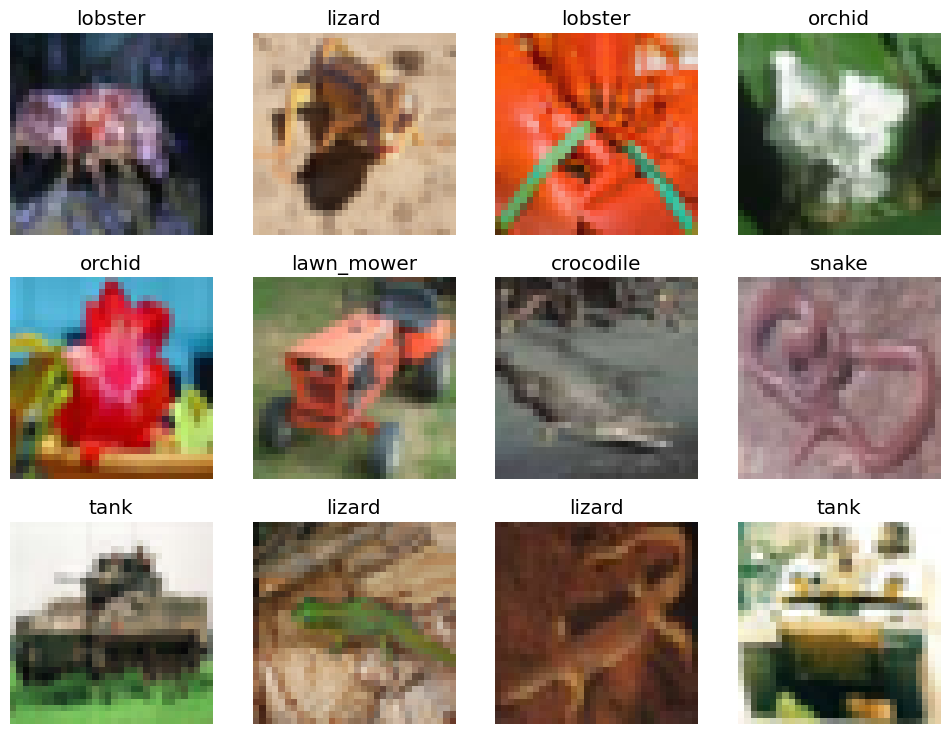

In [ ]:
# Definir el DataBlock
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42), # 10% validación, generados aleatoriamente (seed=42)
    get_y=parent_label,
)

# Crear los DataLoaders
dls = data_block.dataloaders(path/'train')

# Mostrar el lote de imágenes
dls.show_batch(max_n=12)

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dls.train_ds))
print('Numero de ejemplos de validacion:', len(dls.valid_ds))

Example of training data


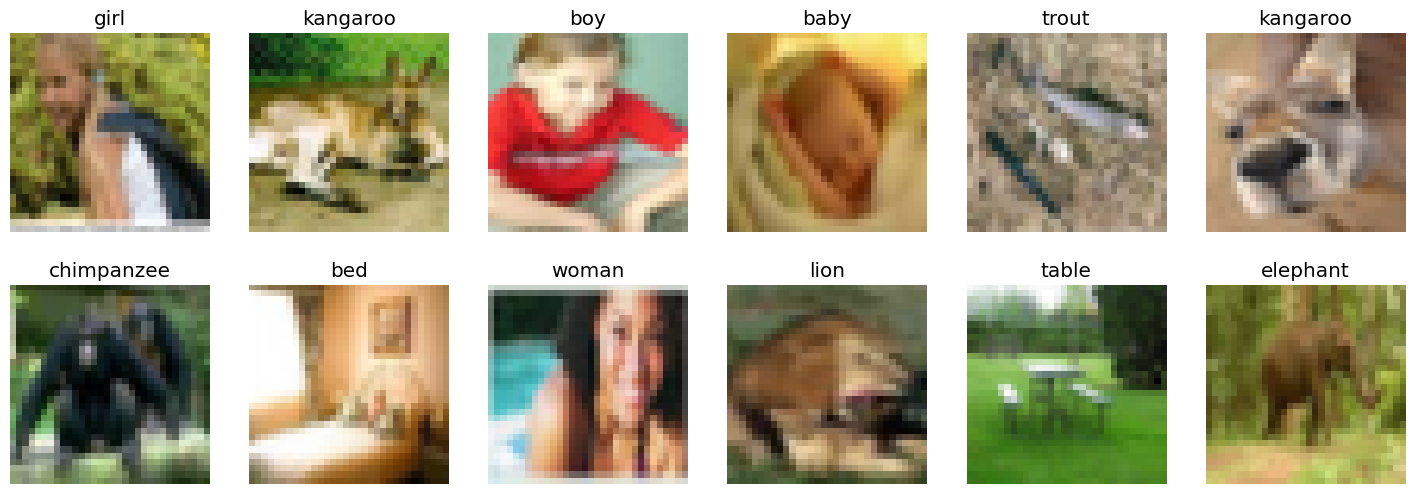

In [ ]:
print('Example of training data')
dls.train.show_batch(max_n=12, nrows=2)

Example of validation data


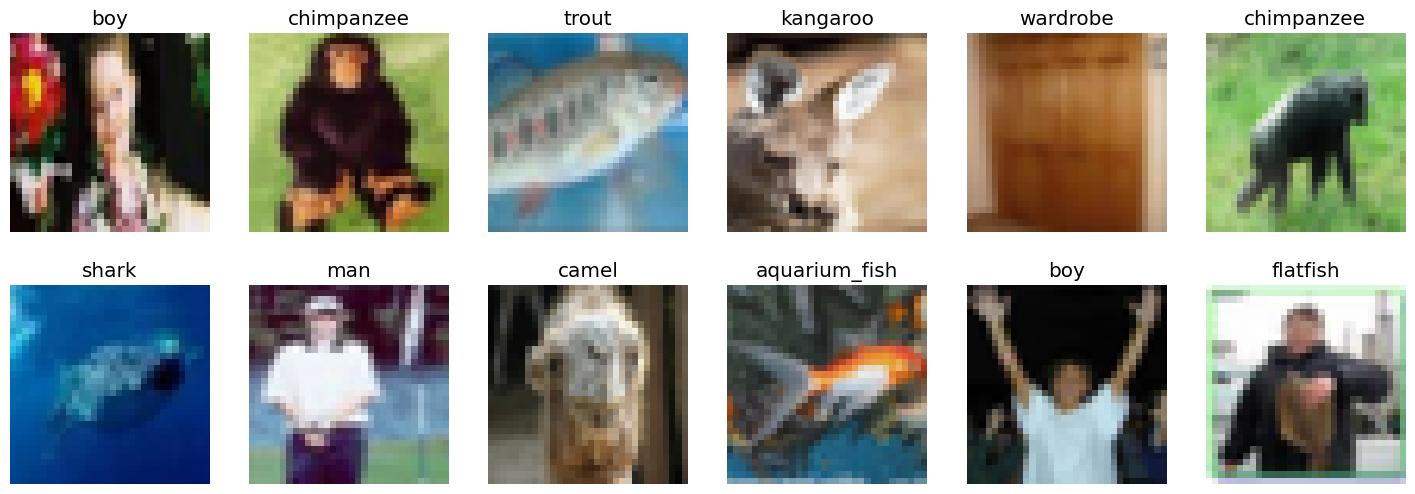

In [ ]:
print('Example of validation data')
dls.valid.show_batch(max_n=12, nrows=2)

Finalmente hacemos lo mismo con el dataset CIFAR100

## **CREACIÓN DE LA RED BASENET**.

Como vimos `Sigmoid`, `Tanh`, y `ReLU` son funciones de activación que no procesan parámetros ni añade pesos, pero sí transforman las salidas de las capas anteriore. Vamos a explicar cada una de las capas que componen el modelo BaseNet

<h2><u>1. Convolution</u></h2>

La fórmula para calcular el tamaño de salida después de aplicar una operación de convolución es:

$$
Output (size) = \frac{N +2P -F}{stride} + 1
$$

- $N$ (Tamaño de la entrada): Representa la dimensión de la imagen de entrada (alto o ancho).

- $P$ (Padding): Es la cantidad de píxeles añadidos alrededor de los bordes de la imagen de entrada, como vimos en la anterior práctica.

- $F$ (Tamaño del filtro o kernel): Es la dimensión del filtro (o kernel) que se usa para aplicar la convolución.

- $Stride$ (Paso): Representa el número de píxeles que el kernel "avanza" en cada paso durante la convolución. Por defecto es 1.


Luego con esto sabemos que para la primera capa se tiene una entrada 32x32 ($N=32$), ademas de un padding de 0 ($P=0$), un kernel 9x9 ($F=9$) y un stride que por defecto siempre es 1 ($Stride=1$). Por lo que esta capa, aplicará convoluciones de 9x9x5, obteniendo como resultado una dimensión de 24x24.

$$
Output (size) = \frac{32 +2\cdot0 -9}{1} + 1 = 23 + 1 = 24
$$

Ya que hay que extender toda la profundidas del nivel anterior, los pesos son $(9\cdot9\cdot3\cdot+ 1)\cdot5$. Se le suma $+1$ ya que este corresponde al *bias* de cada filtro.

<br>

<h2><u>2. Sigmoide</u></h2>

Es una función de activación,cuya fórmula es:
$ \sigma(x) = \frac{1}{1 + e^{-x}}$

Esta función transforma los valores en un rango entre 0 y 1, pero no cambia la dimensionalidad del volumen sobre el que se aplica. Vemos que nuestra convolución genera un volumen de salida de dimensiones 24x24xCanales, la sigmoide no modifica estas dimensiones, ya que opera punto a punto sobre cada valor.

Tradicionalmente se usaban funciones de activación como esta, pero en esta arquitectura utilizaremos `ReLU`, como se explicará más adelante, debido a sus muchas ventajas en comparación.

<br>

<h2><u>3. MaxPooling</u></h2>

Esta operación, reduce la dimensionalidad de la imagen o las características, ayudando a disminuir el número de parámetros y cálculos, además de introducir invariancia a las pequeñas traslaciones de la entrada. Además,  si la entrada (como una imagen o un mapa de características) se desplaza ligeramente, la mayoría de los valores generados por la operación de pooling no se verán afectados.Específicamente, se aplica a una región de la imagen y toma el valor máximo de la misma.

Por ejemplo, si tenemos una imagen de tamaño 4x4 y contamos con un filtro 2x2 y un stride de 2 (lo que significa que el filtro se mueve dos pasos a la vez), generará la siguiente salida :

<img src="https://production-media.paperswithcode.com/methods/MaxpoolSample2.png" width=600>

Esta capa no añade pesos algunos. Por lo que teniendo nuestro filtro 2x2, y una imagen 24x24, al aplicar `Max Pooling` lo que hará es reducir la imagen a la mitad, es decir 12x12. La cual podemos verificar usando la formula:

$$Output(size)=\frac{N+2P−F}{stride}+1 = \frac{24+0−2}{2}+1 = 11 + 1 = 12$$


<br>


<h2><u>4. Convolution</u></h2>

Tendremos otro bloque convolucional, con un kernel 7x7 y nuestra actual dimension 12x12, con los pesos $(7\cdot7\cdot5 + 1)\cdot10$. Se realizaran convoluciones de 7x7x10.

Finalmente, esta convolución nos dará a una dimensionalidad de 6x6, con volumen 6x6x10:

$$Output(size)= \frac{12+0−2}{2}+1 = 5 + 1 = 6$$


<br>


<h2><u>5. Hiperbólica Tangente</u></h2>

Para esta función de activación, usaremos `ReLU` después de la convolución porque introduce no linealidad de manera eficiente, lo que permite que la red aprenda relaciones más complejas en los datos. Además, evita el problema del gradiente desvanecido, es computacionalmente más simple y rápida de calcular, y facilita un entrenamiento más rápido y efectivo, mejorando la eficiencia de la red neuronal. Dejará la dimensionalidad tal como está (6x6).

El problema del **gradiente desvanecido** ocurre cuando se usan funciones de activación como la *sigmoide* o *tangente hiperbólica*, que tienden a saturarse en sus extremos (cerca de 0 o 1). Cuando esto pasa, los gradientes que se calculan durante la propagación hacia atrás (*backpropagation*) se vuelven muy pequeños. Como resultado, los gradientes que actualizan los pesos de las capas anteriores también se hacen casi cero, lo que impide que el modelo aprenda correctamente. Además, dado que el gradiente de la sigmoide alcanza un máximo de 0.25, cada vez que el error se propaga hacia atrás, el valor del gradiente se reduce, especialmente en redes profundas, donde las capas más bajas reciben gradientes tan pequeños que el aprendizaje se vuelve muy lento o incluso se detiene. (“[Yes, you should understand backprop](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b)” *by Andrej Karpathy*)

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*gkXI7LYwyGPLU5dn6Jb6Bg.png">


<br>

<h2><u>6. Fully-connected</u></h2>

Teniendo 10 de mapas de activación de tamaño 6x6, al hacer el *flattening*  tendremos un total de $6\cdot6\cdot10 = 360$ unidades. Y tendriamos un total de pesos de $360\cdot50+50$, ya que en este caso el bias es 50 porque cada una de las 50 neuronas de salida tiene su propio parámetro.

Luego, la operación `Flatten` se utiliza para convertir el volumen de características extraídas por las capas convolucionales (un conjunto de mapas de características con altura, ancho y profundidad) en un vector unidimensional. Esto es necesario porque las capas completamente conectadas (fully-connected layers) solo pueden procesar vectores como entrada, no volúmenes. Por ello, *Flatten* actúa como un puente entre las capas convolucionales, que trabajan con datos en forma de volúmenes, y las capas densas, que realizan la clasificación o decisión final.

Es por ello que se usa para convertir las características espaciales extraídas por las capas convolucionales en un vector, que es el formato que requiere la capa `Linear` (*Fully-connected*). Esto permite que la capa combine las características y realice la predicción final, como la clasificación.

<img src="https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/73_blog_image_1.png" width=700px>

Entonces, como hemos dicho, la capa **Fully-connected** (`Linear`) se encarga de procesar las características extraídas por las capas convolucionales y preparar la salida para la clasificación. En este caso, reduce las 360 características a 50, lo que permite a la red aprender combinaciones más específicas de esas características.


<br>



<h2><u>7. ReLU</u></h2>

 Posteriormente, se aplica la activación `ReLU`, que introduce no linealidad para capturar relaciones complejas y normaliza las salidas en un rango entre -1 y 1. Esto no solo ayuda a la red a modelar patrones más refinados, sino que también centra los datos alrededor de cero, acelerando el aprendizaje y mejorando la estabilidad del entrenamiento. Por lo que no cambia la dimensionalidad.

 <br>



<h2><u>8. Fully-connected</u></h2>


La segunda capa, `nn.Linear(50, 25)`, toma las 50 características procesadas y genera 25 salidas correspondientes a las clases del problema. Esta capa es la encargada de transformar las combinaciones aprendidas en valores que representen cada clase.

En el flujo típico de una red neuronal convolucional para clasificación, como se muestra en la imagen, primero se extraen características importantes de la imagen a través de capas de convolución y pooling. Ya que estas ayudan a identificar patrones y reducir el tamaño de la imagen, haciendo que el modelo sea más eficiente. Después, hacemos el *flattening* de las características extraídas  y se pasan a través de capas *fully connected* para realizar la clasificación. Finalmente, la capa *softmax* (que explicaremos mas adelante junto a por qué no hay que añadirla manualmente a la red) convierte las salidas en probabilidades, permitiendo que el modelo asigne una probabilidad a cada clase.

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*vkQ0hXDaQv57sALXAJquxA.jpeg">

Por lo que con esto mostrado, vamos a construir nuestra red BaseNet en base a sus capas ya explicadas.


In [ ]:
from torch import nn

BaseNet = nn.Sequential(
  # Conv (9x9)
  # Input | Output channels --> 3 (RGB) | 5
  nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(9,9)),
  nn.ReLU(),

  # MaxPooling (2x2)
  nn.MaxPool2d(kernel_size=(2,2)),

  # Conv (7x7)
  # Input | Output channels --> 5 | 10
  nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(7,7)),
  nn.ReLU(),

  # Flattening
  nn.Flatten(),
  nn.Linear(in_features= 360, out_features=50),  # Primera capa completamente conectada
  nn.ReLU(),

  # Segunda capa completamente conectada
  nn.Linear(in_features= 50, out_features=25),  # Segunda capa completamente conectada
)

<br>

## **CONFIGURAR EL PROCESO DE APRENDIZAJE**

Para la **función de pérdida** usaremos `CrossEntropyLossFlat` (de *fastai* ) en lugar de `CrossEntropyLoss` (de *Pytorch* ). Esto se debe a que las funciones que terminan en *Flat* en *fastai* realizan automáticamente un *flattening* de las predicciones, obteniendo salidas más coherentes y adaptadas al cálculo de la pérdida. Si no utilizamos esta variante, las predicciones podrían conservar dimensiones adicionales, provocando resultados erroneos, como generar múltiples predicciones en lugar de una única predicción por instancia. Esto afecta no solo a los cálculos internos, sino también la interpretación y visualización de las clases predichas.

La pérdida de entropía cruzada es una función diseñada para tareas de clasificación, ya sea binaria o multiclase. Mide la discrepancia entre las etiquetas reales y las probabilidades predichas por el modelo, penalizando fuertemente cuando asigna baja probabilidad a la clase correcta. Esto ayuda al modelo a ajustar sus parámetros y optimizar su precisión en problemas de clasificación, a diferencia de métricas como el error cuadrático medio (MSE), que es más adecuada para regresión y que veremos en el ejercicio 3.

<br>

La fórmula de la pérdida es:

<img src="https://arize.com/wp-content/uploads/2022/11/log-loss-1.png" width=600>

- $y_i$ : Clase real de la instancia $i$, donde $y_i=1$ para la clase positiva y $y_i=0$ para la clase negativa.

- $p(y_i)$: Es la probabildiad predicha para la clase positiva.

- $1 - p(y_i)$: Es la probabilidad de que la clase sea negativa.

La fórmula promedia la pérdida $(-1/N)$sobre todas las instancias y penaliza más cuando el modelo asigna baja probabilidad a la clase correcta, "recompensando" predicciones más precisas. Esto asegura que las predicciones del modelo sean consistentes con las etiquetas reales, donde un valor bajo de pérdida indica mayor precisión.

<br>


Para la **función de activación**, utilizaremos `Softmax`, que generaliza la función sigmoide a múltiples clases. Esta función toma las salidas del modelo y las normaliza, convirtiéndolas en probabilidades interpretables para cada clase. Softmax garantiza que la suma de todas las probabilidades sea igual a 1, lo que permite que cada valor represente la probabilidad de que la entrada pertenezca a una clase específica.

<br>

<img src="https://miro.medium.com/v2/resize:fit:586/1*bol3L-WNVacCscvG-rlypQ.png"  width=300>

- $\sigma$ = Softmax.

- $\vec z$ = Vector de entrada.

- $\sigma^{z_i}$ = Función exponencial estándar para el vector de entrada.

- $K$ = Numero de clases en el clasificado multiclases.

- $e^{z_j}$ = Función exponencial estándar para el vector de salida.



En conclusión, **no es necesario incorporar manualmente `nn.Softmax()`** en la capa final de la red cuando usamos `CrossEntropyLossFlat`, ya que esta función de pérdida incluye internamente una operación de **Softmax**, tal como se explica en la [documentación oficial de fastai](https://docs.fast.ai/losses.html). Esta implementación de `CrossEntropyLossFlat` realiza automáticamente el *flattening* de las predicciones y los objetivos, y aplica la función de softmax en la última dimensión, lo que hace innecesaria la adición manual de dicha operación.

Si añadiéramos `nn.Softmax()` manualmente, estaríamos aplicando la función de softmax dos veces, lo cual podría provocar resultados incorrectos y afectar el rendimiento del modelo durante el entrenamiento.

Entonces, utilizamos el objeto `Learner` de FastAI para configurar el proceso de entrenamiento del modelo `BaseNet` con el optimizador Adam, empleando la función de pérdida `CrossEntropyLossFlat()`. Incluimos un *callback* `EarlyStoppingCallback` con una paciencia de 5, lo que significa que el entrenamiento se detendrá automáticamente si la pérdida de validación (`valid_loss`) no mejora durante 5 épocas consecutivas, optimizando así los recursos al evitar entrenamiento innecesario.

Finalmente, usamos `lr_find()` para identificar la tasa de aprendizaje ideal para el modelo antes de entrenarlo.

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

0.0005754399462603033


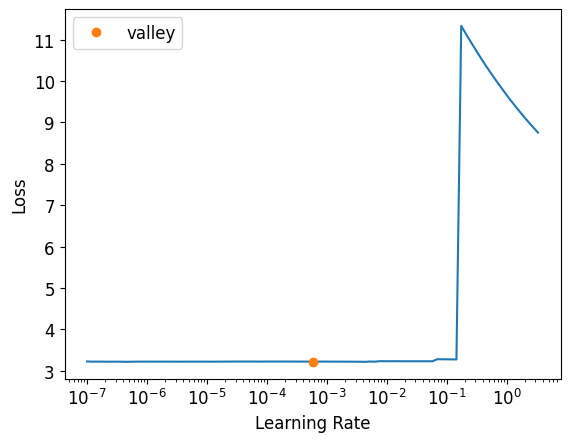

In [ ]:
# Creamos el learner
learn = Learner(
    dls,
    BaseNet,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, F1Score(average='weighted')],
    opt_func=Adam,
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)]
)

lr = learn.lr_find()
print(lr[0])

Hacemos el `summary` para verificar que esté construida correctamente la arquitectura.

La red comienza con una entrada de tamaño *64 x 3 x 32 x 32*, representando un lote de 64 imágenes RGB de 32x32 píxeles. La primera capa convolucional aplica filtros que reducen las dimensiones espaciales a *24 x 24 x 5*, debido al tamaño del kernel, y genera 5 mapas de características. Posteriormente, el MaxPooling reduce como se comentó las dimensiones espaciales a la mitad, dejando *12 x 12 x 5*.

La segunda capa convolucional produce *6 x 6 x 10*, aumentando los mapas de características a 10. Tras aplicar un *flattening*, la salida se convierte en un vector de 360 características. Finalmente, las capas densas (fully connected) transforman este vector, primero a 50 características intermedias y luego a la salida final de 25 clases, que es el objetivo del modelo.

In [ ]:
learn.summary()

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 5 x 24 x 24    
Conv2d                                    1220       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 10 x 6 x 6     
Conv2d                                    2460       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 360            
Flatten                                                        
____________________________________________________________________________
                     64 x 50     


<br>

## **ENTRENAMIENTO DEL MODELO**

Para entrenar el modelo definido en el `Learner` durante un máximo de 25 épocas, utilizamos el comando `learn.fit_one_cycle(25, lr_max=lr[0])`. Aquí, `lr[0]` corresponde a la tasa de aprendizaje máxima recomendada, obtenida previamente con el método `lr_find()`. Este valor, conocido como el "valley", indica el punto donde la pérdida comienza a disminuir rápidamente y es adecuado para un entrenamiento estable. Durante el proceso de `fit_one_cycle`, la tasa de aprendizaje empieza baja, luego aumenta para explorar mejor el espacio de parámetros, y finalmente disminuye para estabilizar el modelo y mejorar su precisión al final del entrenamiento.

In [ ]:
# Entrenar por un máximo de 25 épocas
learn.fit_one_cycle(25,lr_max=lr[0])  # Usando el valor de lr encontrado anteriormente

Usando `recorder.plot_metrics()` mostramos la evolución, por épocas de entrenamiento, tanto de la función de pérdida (en entrenamiento y validación) como de la accuracy (en validación) y el F1 score (weighted) (en validación).

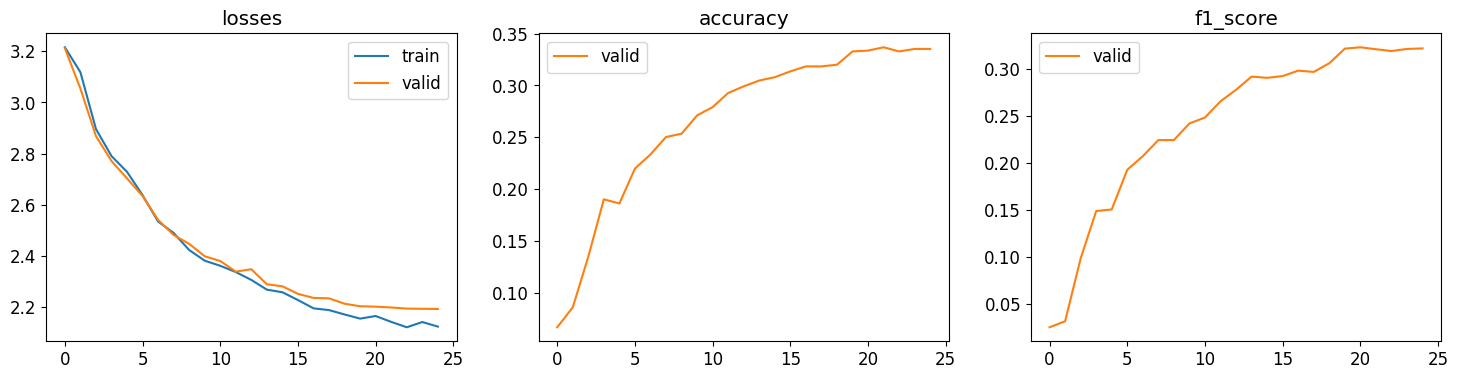

In [ ]:
learn.recorder.plot_metrics()


<br>

## **EVALUACIÓN DEL MODELO**



Creamos una funcion para mostrar la matriz de confusión y la predicción en el conjunto de *entrenamiento*, *validación* y *prueba*.

In [ ]:
def print_accuracy_and_matrix(dl, tipo_conjunto):
  print(f"Conjunto de {tipo_conjunto}")
  interp = ClassificationInterpretation.from_learner(learn, 1, dl=dl)
  cm = interp.confusion_matrix()
  print(f'Número de ejemplos:', np.sum(cm))
  print(f"Precisión: ", np.sum(np.diagonal(cm))/np.sum(cm)*100)
  interp.plot_confusion_matrix(figsize=(12, 12),title=f"Matriz de Confusión para el conjunto de {tipo_conjunto}")
  interp.most_confused(min_val=10)

  return interp

Conjunto de Entrenamiento


Número de ejemplos: 11250
Precisión:  36.96888888888889


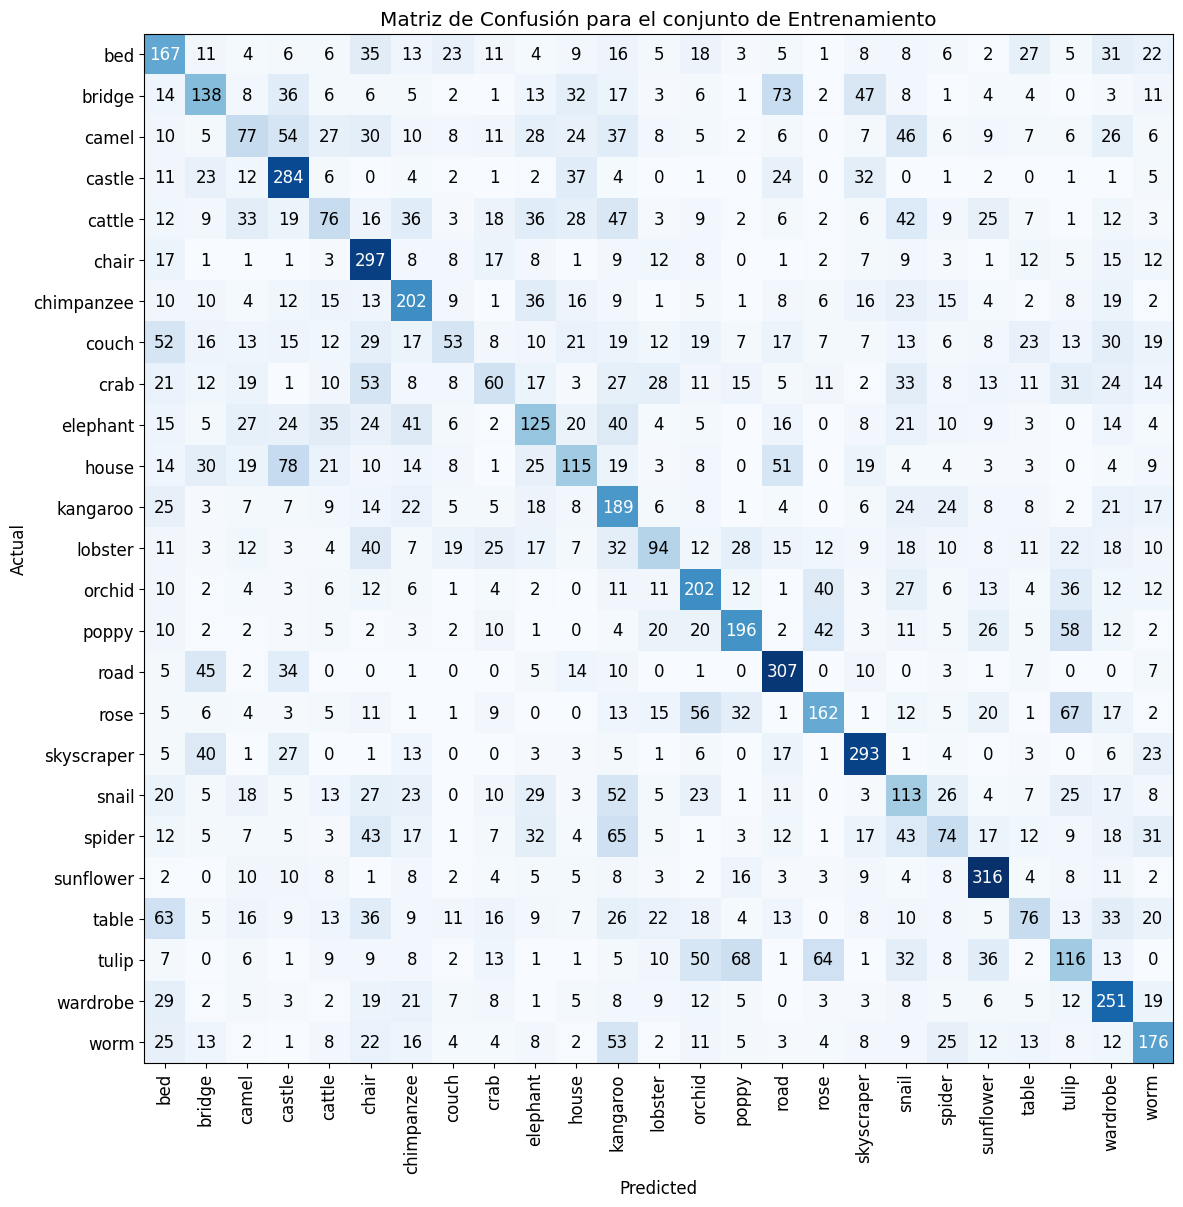

In [ ]:
# Precisión en el conjunto de entrenamiento
train_dl = learn.dls.train
interp_train = print_accuracy_and_matrix(train_dl, "Entrenamiento")

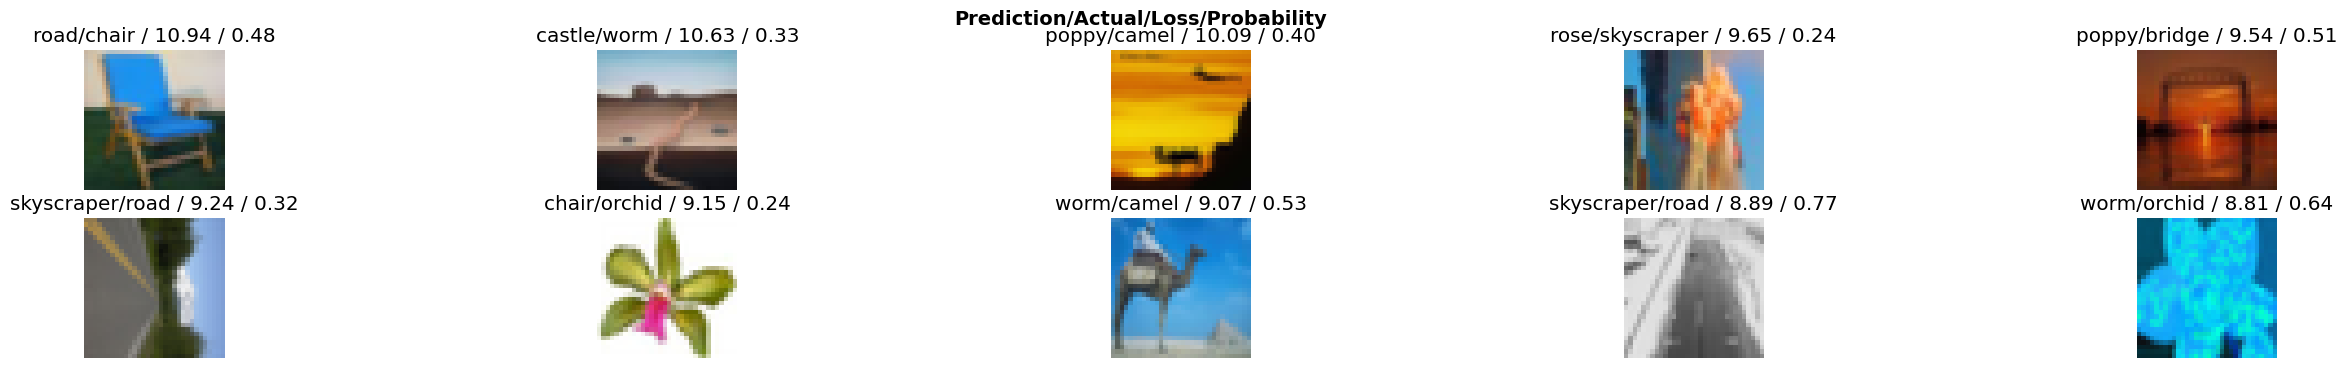

In [ ]:
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

Conjunto de Validación


Número de ejemplos: 1250
Precisión:  33.52


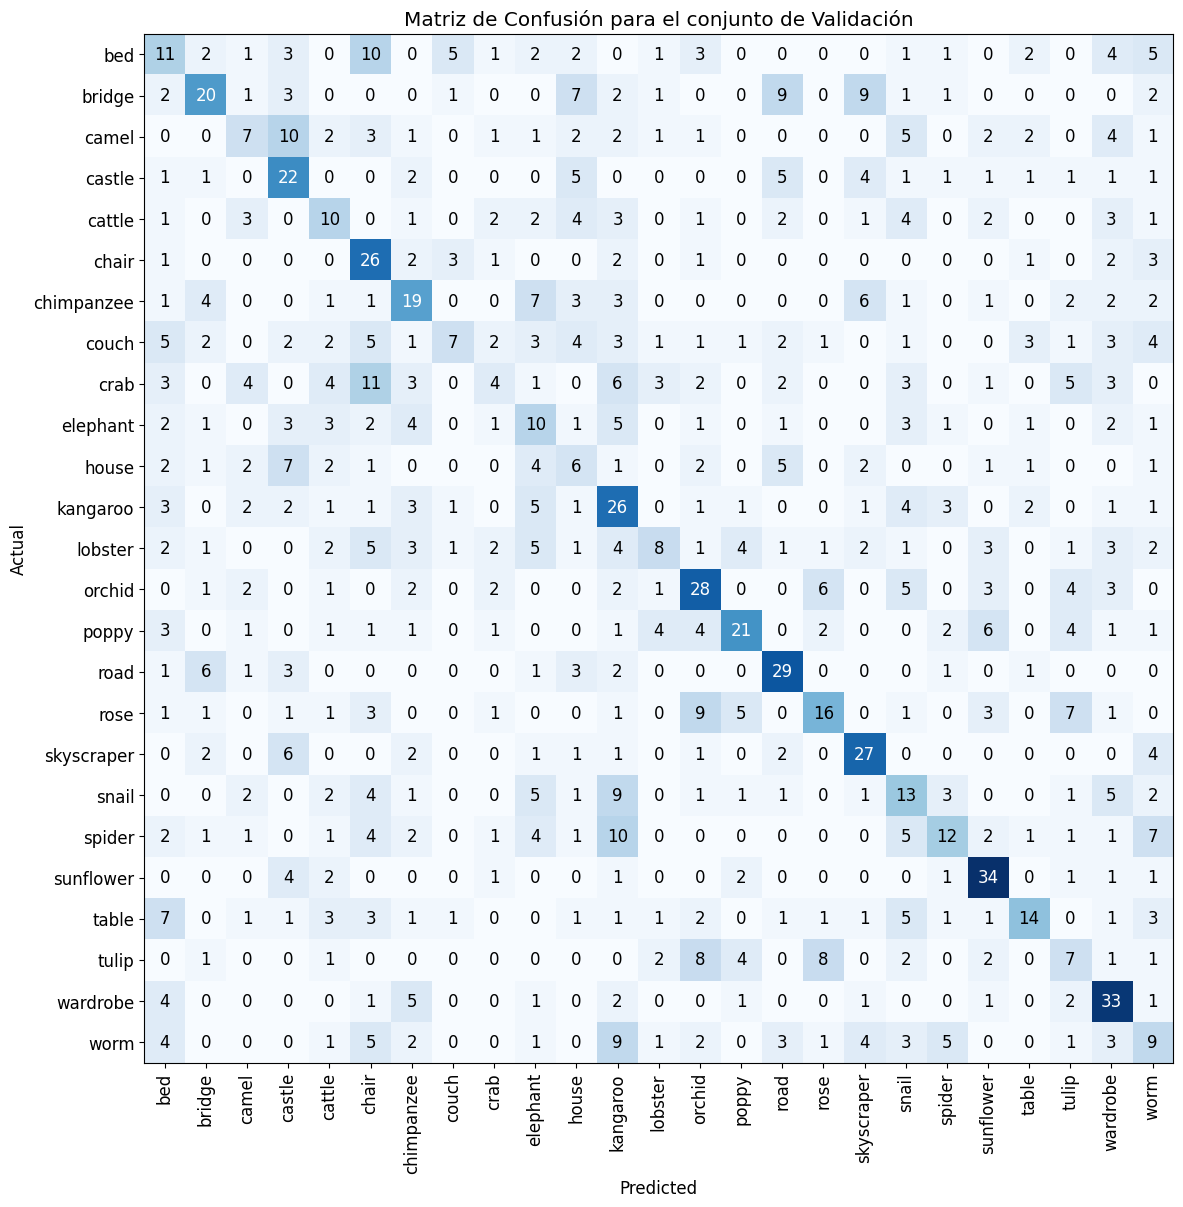

In [ ]:
# Precisión en el conjunto de validación
valid_dl = learn.dls.valid
interp_valid = print_accuracy_and_matrix(valid_dl, "Validación")

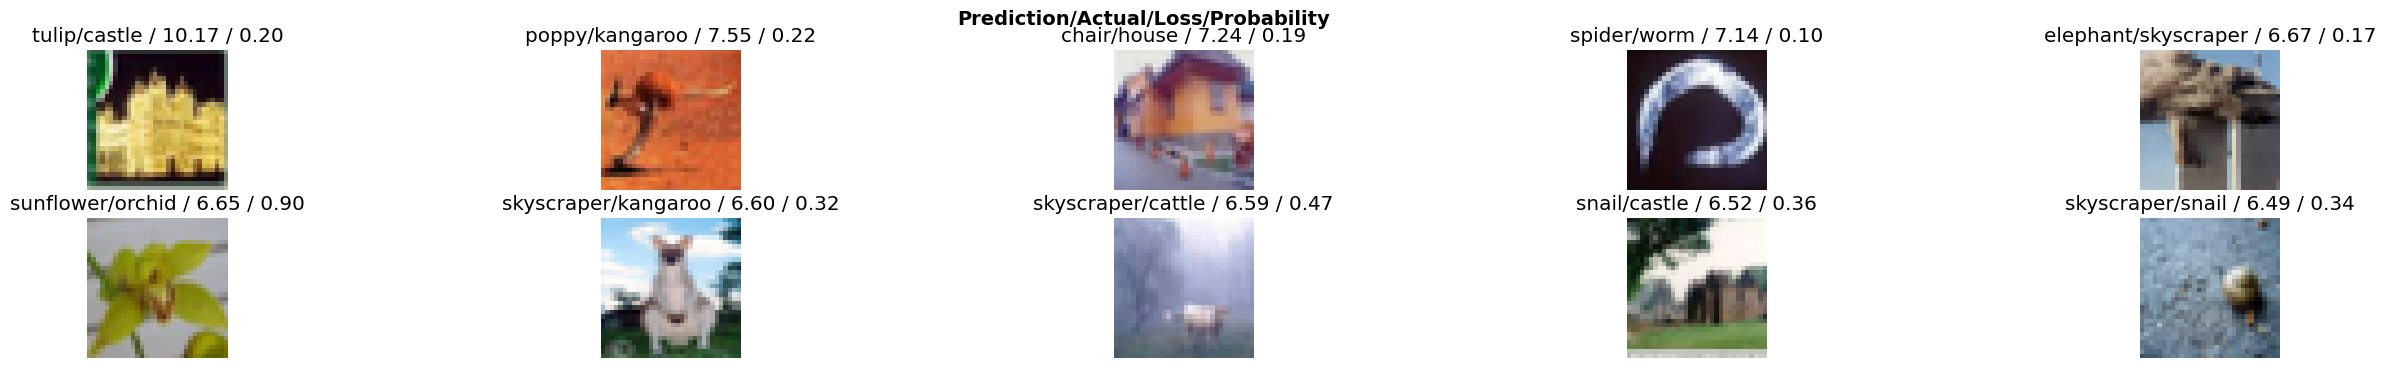

In [ ]:
interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))

Conjunto de Prueba


Número de ejemplos: 2500
Precisión:  34.4


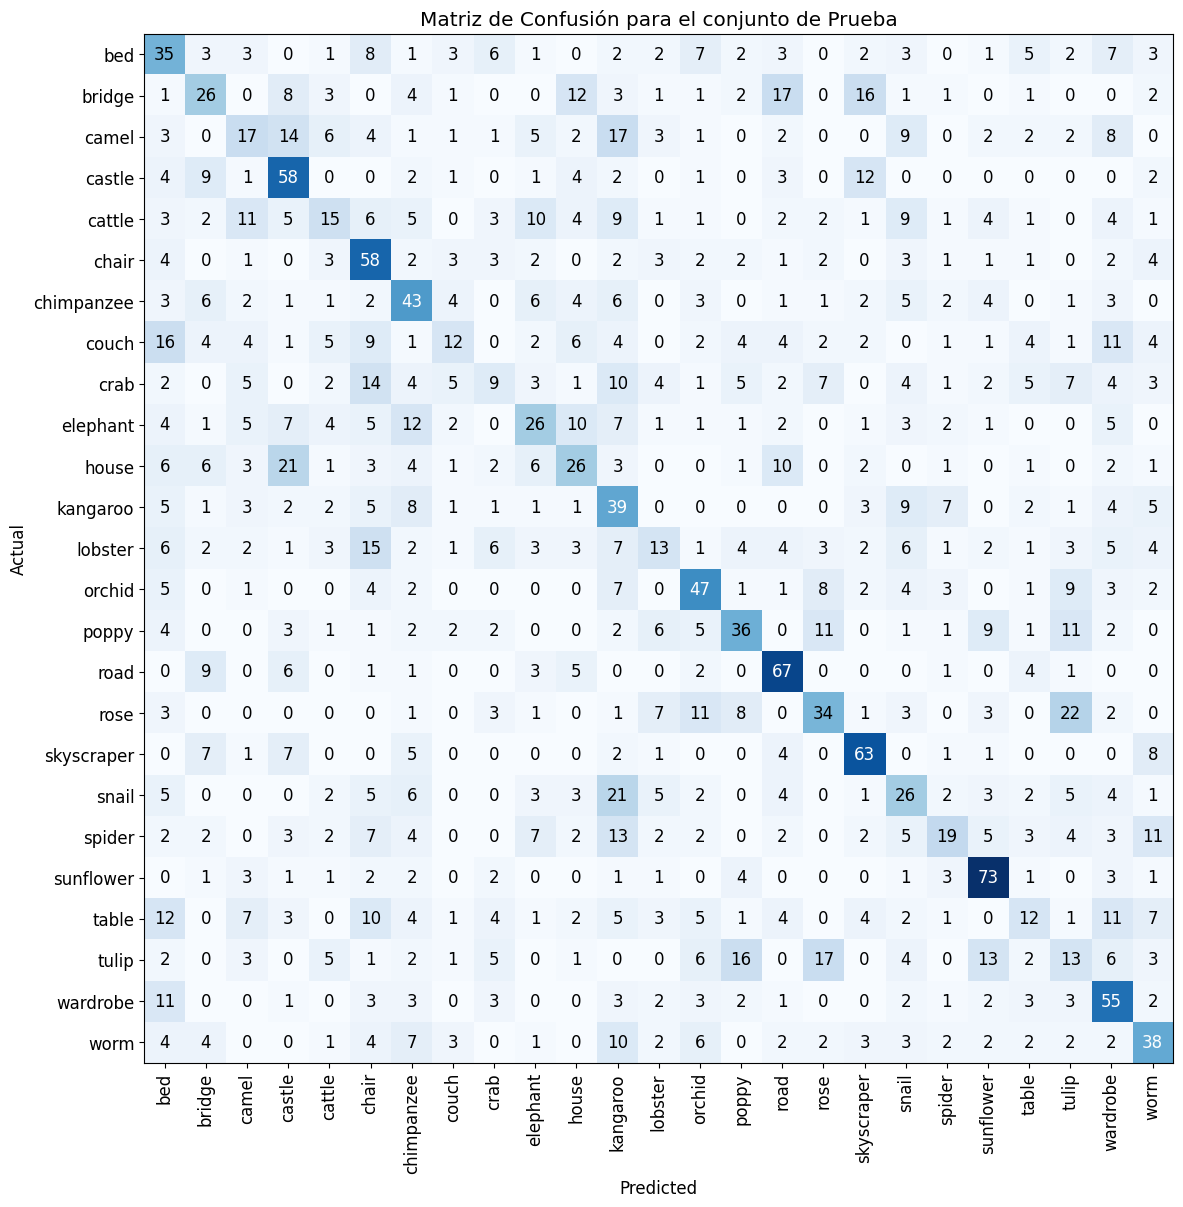

In [ ]:
# Precisión en el conjunto de prueba
test_dl = learn.dls.test_dl(files_test, with_labels=True)
interp_test = print_accuracy_and_matrix(test_dl, "Prueba")

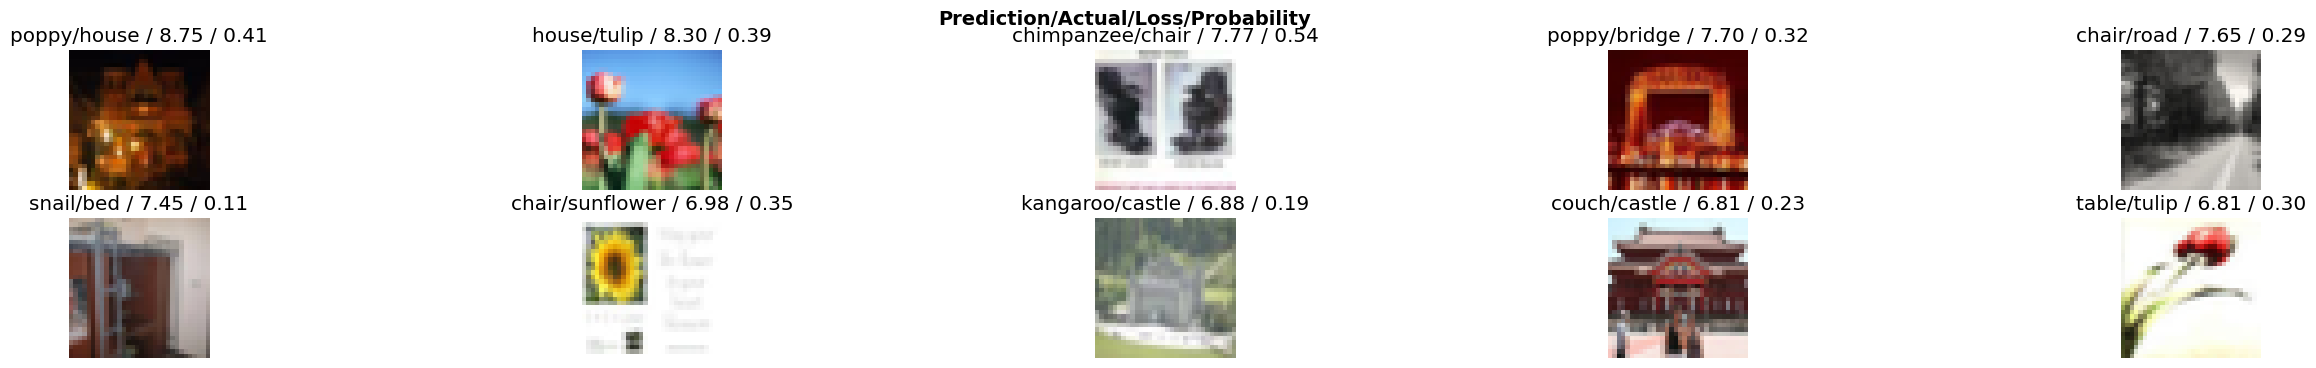

In [ ]:
interp_test.plot_top_losses(10, nrows=2, figsize=(32,4))



---



---



---



# <font color='#ADD8E6'> **Ejercicio 2:** **Mejoras sobre el modelo BaseNet (4 puntos)**
<font color='#ADD8E6'>Ahora el objetivo es crear una versión mejorada del modelo _Base Net_ (implementado en el anterior apartado). Para ello, se puede experimentar con distintas funciones de activación, funciones de pérdida, una mayor o menor profundidad de la red, un mayor o menor número de filtros por bloque convolucional, y/o diferentes técnicas de regularización u optimización, entre otras. De hecho, los alumnos deben sentirse libres para experimentar e incorporar todas las modificaciones que consideren pertinentes, incluyendo elementos no vistos ni en teoría ni en prácticas (por ejemplo, componentes que hayan podido descubrir a través de la revisión de artículos científicos). **Se valorará la originalidad y complejidad de la propuesta realizada.**

<font color='#ADD8E6'>Es necesario destacar que **es imprescindible justificar de la mejor forma posible las decisiones tomadas** (ya sea mediante evidencia empírica o mediante literatura científica), **así como el rendimiento obtenido** (esto es, intentar explicar qué es lo que hace que mejore tanto el rendimiento). También es importante remarcar que **las mejoras introducidas, dentro de lo posible, deben realizarse de forma incremental**, es decir, no basta con crear directamente (de forma mágica) un único modelo y evaluarlo:  **es necesario justificar y describir qué pasos y resultados intermedios nos han llevado a diseñar ese modelo concreto**. Se debe describir cada una de las mejoras incorporadas, así como analizar los resultados obtenidos (del mismo modo que se hizo en el Ejercicio 1, y empleando los mismos criterios de partida; por ejemplo, usando un $10\%$ de los ejemplos de entrenamiento para validación). También es necesario, al igual que en el Ejercicio 1, desglosar el número de parámetros del modelo final, y se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido correctamente y que el número de parámetros se corresponde con lo esperado.  

<font color='#ADD8E6'>Como referencia para los estudiantes, se espera que la _accuracy_ en validación alcance, como mínimo, el $65\%$.


## **CREACIÓN DE LA RED BASENET OPTIMIZADA**.

Lo primero será crear un nuevo DataBlock usando **`Normalize.from_stats(*imagenet_stats)`**, esto se compone de lo siguiente:

- `Normalize()`: Aplica una normalización a las imágenes. Escala los valores de cada canal de estas para que tengan una media y desviación estándar, normalmente una media aproximada a 0 y una desviación de 1. Así ayudamos al modelo a aprender mas rápido y de forma eficiente.

- `from_stats(*imagenet_stats)`: Utiliza estadísticas ya definidas del conjunto de datos ImageNet y las aplica a las imágenes de entrada. Esto es muy util ya que estos modelos preentrenados esperan entradas normalizadas de esta manera. Donde usar estas estadísticas asegura que las imágenes de entrada tengan una distribución similar a la de las imágenes con las que el modelo fue originalmente entrenado.
Algo similiar se verá en el ejercicio 3, donde se aprovechan las características ya aprendidas de nuestro modelo.


También en el DataLoader he decidido usar **`bs=16`** (tamaño de lote de 16), ya que, aunque normalmente uso **`bs=64`**, este valor más pequeño puede reducir la carga en la GPU, lo que facilita entrenar modelos preentrenados sin que se agote la memoria. Aunque un lote más pequeño puede hacer que la optimización sea peor y las estimaciones sean más ruidosas, pero permite actualizaciones más frecuentes de los gradientes, lo que puede acelerar el aprendizaje. De esta forma, **`bs=16`** ofrece un buen equilibrio entre la eficiencia del entrenamiento y la capacidad del hardware disponible.

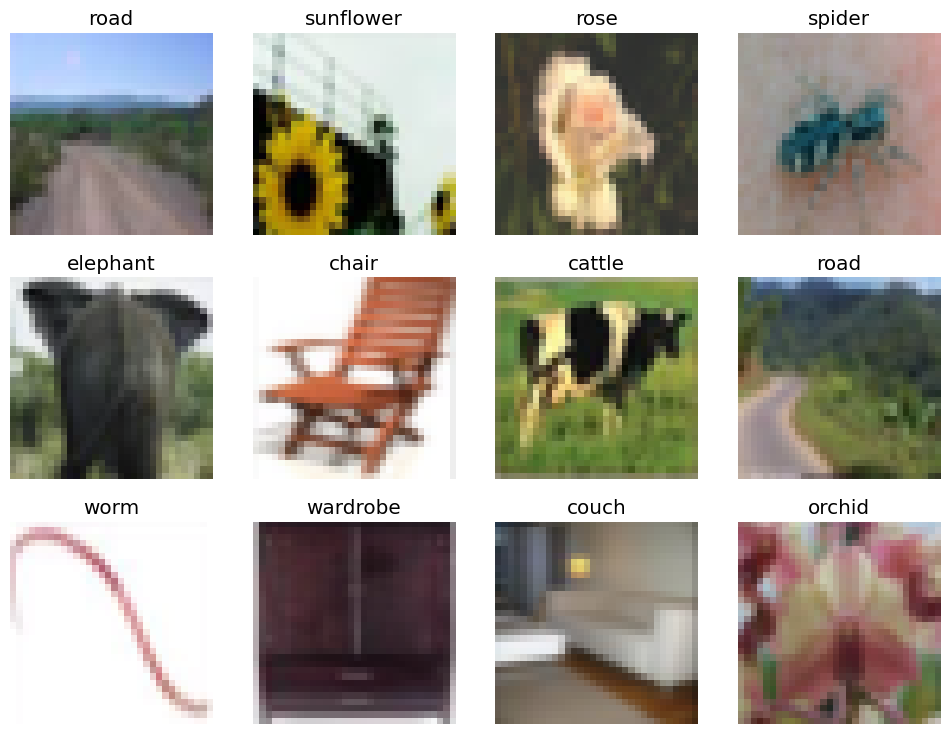

In [ ]:
# Definir el DataBlock con la normalización
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # 10% validación, generados aleatoriamente (seed=42)
    get_y=parent_label,
    batch_tfms=Normalize.from_stats(*imagenet_stats)
)

# Crear los DataLoaders
dls = data_block.dataloaders(path/'train', bs=16)
dls.show_batch(max_n=12)

Al modelo BaseNet, le he añadido `Batch Normalization`. Como ya se ha visto, esta una técnica que normaliza las activaciones de cada mini-batch en redes neuronales para reducir el *Internal Covariate Shift*, lo que estabiliza el entrenamiento y acelera la convergencia. Esto mejora la eficiencia y robustez del modelo, además de actuar como un regularizador al introducir ruido durante el cálculo de la media y varianza, ayudando a prevenir el sobreajuste.

Pasos de Batch Normalization:
1. **Cálculo de la media y varianza**: Para cada canal en la salida de una capa, se calcula la media y la varianza  en el mini-lote actual.

2. **Normalización**: Cada activación $x_i$ del mini-lote se normaliza utilizando la media y la varianza calculadas.

3. **Escalado y desplazamiento**: Se introducen parámetros aprendibles $\gamma$ (escala) y $\beta$ (desplazamiento) para que la red pueda ajustar la distribución normalizada según sea necesario.

4. **Inferencia**: Durante la evaluación, se utiliza una media y varianza acumuladas (promedios móviles) calculadas durante el entrenamiento para normalizar las activaciones, garantizando un comportamiento consistente del modelo.

In [ ]:
BaseNet_batch = nn.Sequential(
  # Conv (9x9)
  # Input | Output channels --> 3 (RGB) | 5
  nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(9,9)),
  nn.BatchNorm2d(5),
  nn.ReLU(),

  # MaxPooling (2x2)
  nn.MaxPool2d(kernel_size=(2,2)),

  # Conv (7x7)
  # Input | Output channels --> 5 | 10
  nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(7,7)),
  nn.BatchNorm2d(10),
  nn.ReLU(),

  # Flattening
  nn.Flatten(),
  nn.Linear(in_features= 360, out_features=50),
  nn.BatchNorm1d(50),
  nn.ReLU(),

  # Segunda capa completamente conectada
  nn.Linear(in_features= 50, out_features=25),
)

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

0.005248074419796467


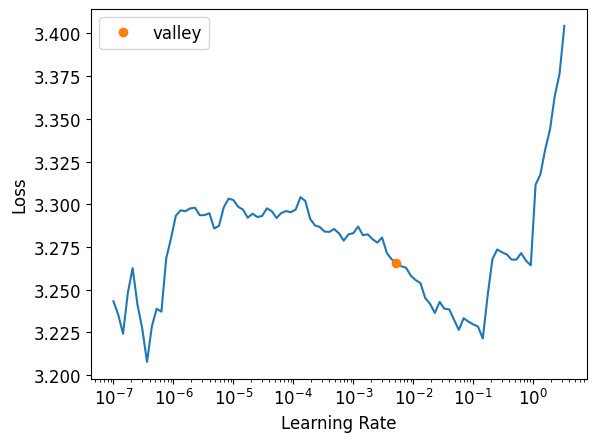

In [ ]:
learn = Learner(
    dls,
    BaseNet_batch,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, F1Score(average='weighted')],
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)]
)

lr = learn.lr_find()
print(lr[0])

Al hacer un `summary()`, vemos que la arquitectura se ha construido correctamente, como se puede observar en el resumen donde la entrada está definida con un tamaño de lote de 16 imágenes de dimensiones 32x32 con 3 canales (RGB). Las dimensiones de salida de cada capa son las esperadas según la estructura definida. El número total de parámetros, *23,135*, corresponde a la suma de los parámetros de todas las capas, lo que confirma que el modelo está correctamente diseñado y que los cálculos de parámetros son correctos.

In [ ]:
learn.summary()

Sequential (Input shape: 16 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 5 x 24 x 24    
Conv2d                                    1220       True      
BatchNorm2d                               10         True      
ReLU                                                           
____________________________________________________________________________
                     16 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     16 x 10 x 6 x 6     
Conv2d                                    2460       True      
BatchNorm2d                               20         True      
ReLU                                                           
____________________________________________________________________________
                     16 x 360            
Flatten                                       

Entrenamos el modelo por 25 épocas.

In [ ]:
learn.fit_one_cycle(25, lr_max=lr[0])

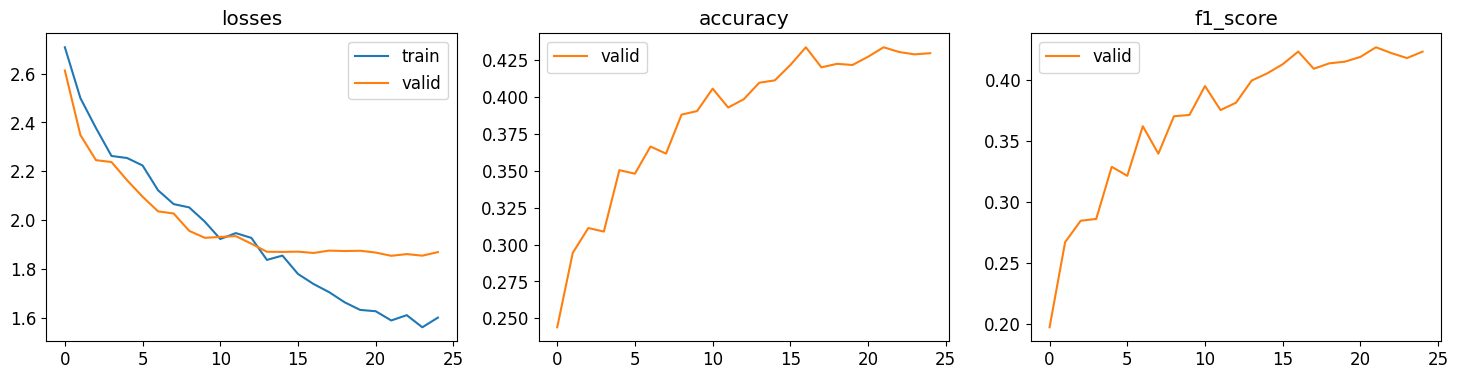

In [ ]:
learn.recorder.plot_metrics()

En los resultados finales, este nuevo  modelo ha obtenido mejores resultados que el modelo base del ejercicio anterior, que alcanzaba solo un 30% de precisión. En este caso, la precisión del conjunto de entrenamiento es del **58.56%**, mientras que los conjuntos de validación y prueba alcanzan un **42.96%** y **43.16%**, respectivamente. Sin embargo, hay un indicio de sobreajuste, ya que la precisión en el conjunto de entrenamiento es significativamente mayor que en los conjuntos de validación y prueba, lo que sugiere que el modelo podría estar ajustándose demasiado a los datos de entrenamiento.

In [ ]:
# Función para obtener solo precisión
def calcular_precision(learn, dl, tipo_conjunto):
    print(f"Conjunto de {tipo_conjunto}")

    interp = ClassificationInterpretation.from_learner(learn, dl=dl)
    cm = interp.confusion_matrix()
    print(f'Número de ejemplos:', np.sum(cm))
    precision = np.sum(np.diagonal(cm)) / np.sum(cm) * 100
    print(f"Precisión: {precision:.2f}%\n")

# Obtener precisión para entrenamiento
calcular_precision(learn, learn.dls.train, "Entrenamiento")

# Obtener precisión para validación
calcular_precision(learn, learn.dls.valid, "Validación")

# Obtener precisión para prueba
test_dl = learn.dls.test_dl(files_test, with_labels=True)
calcular_precision(learn, test_dl, "Prueba")

Conjunto de Entrenamiento


Número de ejemplos: 11250
Precisión: 58.56%

Conjunto de Validación


Número de ejemplos: 1250
Precisión: 42.96%

Conjunto de Prueba


Número de ejemplos: 2500
Precisión: 43.16%



---



---



---

## **AÑADIR BLOQUES CONVOLUCIONALES AL MODELO**

En este caso, he configurado los **DataLoaders (dls)** de manera similar al modelo anterior, pero añadiendo `aug_transforms`. Este aplica diversas transformaciones para aumentar los datos, incluyendo rotaciones, zoom, ajustes de iluminación y cambios en la perspectiva, lo que mejora la fiabilidad del modelo al simular variaciones reales en las imágenes.

Esto puede dar mejores resultados porque introduce mayor variabilidad en los datos de entrenamiento mediante las transformaciones. Ayuda al modelo a aprender características más generales y robustas en lugar de ajustarse únicamente a los patrones específicos de las imágenes originales. Al simular diferentes escenarios que el modelo podría encontrar en datos no vistos, las transformaciones aumentan su capacidad de generalización, lo que generalmente debería dar un mejor resultados.

En este caso, también he configurado un tamaño de lote `bs=64` (por defecto) en lugar de 16. Con esto nos basta para aprovechar mejor los recursos computacionales y procesar más datos en paralelo durante el entrenamiento. Mejora la eficiencia, y ayudando a que las actualizaciones de los gradientes sean más estables al reducir el ruido introducido por mini-batches más pequeños.

In [ ]:
# DataBlock con Normalización y Aug_transform
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # 10% validación
    get_y=parent_label,
    batch_tfms=[
        *aug_transforms(
            flip_vert=True,
            max_rotate=30.0,
            max_zoom=1.1,
            max_lighting=0.2,
            p_affine=0.75,
            p_lighting=0.75
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
)

# Crear los DataLoaders
dls = data_block.dataloaders(path/'train')

Para mejorar los resultados y resolver el sobreajuste, he diseñado un modelo con bloques convolucionales más complejos que combinan capas de convolución, normalización por lotes y activación ReLU. Estas permiten al modelo capturar características más sofisticadas, aumentando su capacidad de aprendizaje. Aunque no implementan conexiones residuales típico de ResNet,(*son atajos que saltan una o más capas, permitiendo que la entrada de una capa se sume directamente a su salida, permitiendo que las redes sean mucho más profundas sin perder precisión*), los bloques añadidos incrementan la profundidad del modelo, facilitando la extracción de patrones más complejos en las imágenes.

En esta versión, la primera capa convolucional tiene 16 canales de salida (en lugar de 5 como en el modelo anterior), lo que permite capturar más características desde las primeras etapas. Además, he utilizado kernels de 3x3 con padding de 1 en todas las convoluciones. Así aseguro que las dimensiones espaciales de las imágenes se mantengan tras cada operación, permitiendo a la red conservar la resolución mientras aprende patrones locales detallados.

El modelo incluye dos bloques convolucionales adicionales. El primero procesa 16 canales de entrada y genera 32 canales de salida, y el segundo incrementa los canales de 32 a 64. Ambos bloques están seguidos por capas de MaxPooling que reducen progresivamente las dimensiones espaciales de las imágenes de 32x32 a 16x16, luego a 8x8, y finalmente a 4x4, preparando las características para las capas completamente conectadas.

Para la **última convolución**, mantuve el mismo número de canales de entrada y salida para preservar la información y evitar la pérdida de características importantes. Esto permite que el modelo siga extrayendo patrones complejos sin reducir la capacidad de representación, lo que es clave para una clasificación precisa.

<br>

Además, he incluido una capa de **Dropout** con una tasa del 50%, que ayuda a reducir el sobreajuste desactivando aleatoriamente una parte de las neuronas durante el entrenamiento. Esto fuerza a la red a aprender representaciones más generales y a depender menos de características específicas del conjunto de entrenamiento. Estas mejoras hacen que el modelo sea más robusto y generalice mejor a nuevos datos.

<br>

Finalmente, aunque he mantenido la misma estructura básica que el modelo anterior, en esta versión la **primera capa convolucional** se ha ajustado para tener **16 canales de salida**, en comparación con los **5 canales** del modelo anterior. Esto permite una mayor capacidad para extraer características desde el principio, lo que puede ayudar a capturar más información importante en las primeras etapas del procesamiento de las imágenes. Además, usar un **kernel de 3x3 con padding de 1**, como ya se dijo, asegura que las dimensiones espaciales se mantengan, permitiendo que la red pueda aprender patrones locales detallados sin perder resolución en las imágenes.

El primer `Linear` de entrada tiene **64 *4 * 4** unidades, ya que luego de las capas de MaxPooling, las dimensiones espaciales de la imagen original de 32x32 se reducen a 4x4. La salida de la última capa convolucional tiene 64 canales, lo que da un total de **64 * 4 * 4** valores, que son los que se aplanan y se pasan a la capa completamente conectada. Y he utilizado **128 neuronas** como salida de la capa `Linear` porque, en comparación con el modelo anterior que usaba 64, este incrementa la capacidad del modelo para aprender características más complejas antes de llegar a la capa final de clasificación. Aumentando el rendimiento, especialmente cuando se trabaja con un modelo más profundo. Simplemente esto se basa en encontrar equilibrio entre aumentar la capacidad de representación y evitar un incremento excesivo en el número de parámetros.

In [ ]:
# Bloque Residual
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels)
    )

# Modelo con más complejidad
BaseNet_complejo = nn.Sequential(
    # Capa convolucional inicial
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2),  # Reduce de 32x32 a 16x16

    # Primer bloque convolucional
    conv_block(16, 32),
    nn.MaxPool2d(2),  # Reduce las dimensiones de 16x16 a 8x8

    # Segundo bloque convolucional
    conv_block(32, 64),
    nn.MaxPool2d(2),  # Reduce las dimensiones de 8x8 a 4x4

    # Flattening
    nn.Flatten(),

    # Capa completamente conectada
    nn.Linear(64 * 4 * 4, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),

    # Dropout para evitar sobreajuste
    nn.Dropout(0.5),

    # Capa de salida
    nn.Linear(128, 25)  # Salida con 25 clases
)

Como se explicó en **p2_hg.ipynb**, en Fastai se utiliza la clase **Optimizer** que incluye la mayoría de los optimizadores disponibles en PyTorch. En este caso, para usar el optimizador **Adam**, se define una función parcial mediante **`partial(OptimWrapper, opt=optim.Adam)`**. Esto crea un envoltorio alrededor del optimizador **Adam** de PyTorch, permitiendo que sea utilizado de manera más sencilla dentro de la estructura de Fastai. Al usar **`partial`**, se simplifica la forma de crear el optimizador, ya que no es necesario especificar todos los parámetros de configuración de manera manual cada vez que se usa.

0.0004786300996784121


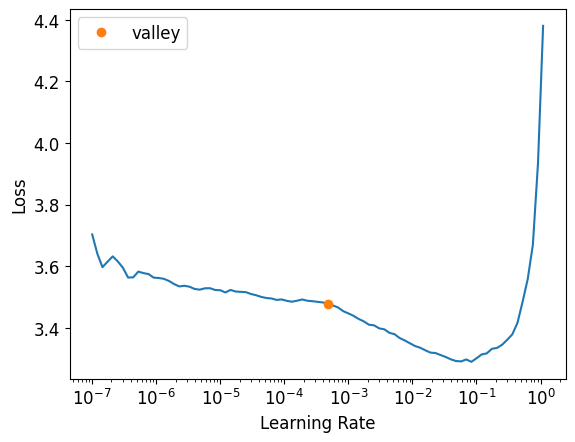

In [ ]:
from fastai.optimizer import OptimWrapper
from torch import optim
from functools import partial

Adam = partial(OptimWrapper, opt=optim.Adam)

learn = Learner(
    dls,
    BaseNet_complejo,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, F1Score(average='weighted')],
    opt_func=Adam,
)

# Buscar la tasa de aprendizaje
lr = learn.lr_find()
print(lr[0])

Al realizar un `summary()` del modelo, podemos confirmar que la arquitectura está construida correctamente. Se observa que la entrada está definida con un tamaño de lote de 64 imágenes de dimensiones 32x32 y 3 canales (RGB). A medida que las imágenes pasan por las capas convolucionales y de max pooling, las dimensiones se reducen progresivamente: de 32x32 a 16x16 después de la primera capa convolucional, a 8x8 tras el primer bloque convolucional y max pooling, y a 4x4 al final del segundo bloque convolucional. Luego, se hace un *flattening* y pasan a través de las capas lineales, donde la salida de 1024 valores se convierte en 128 unidades y, finalmente, en las 25 clases esperadas. El número total de parámetros es de **204,857**, lo que coincide con lo esperado y confirma que el modelo está correctamente diseñado y los cálculos de parámetros son precisos.

In [ ]:
learn.summary()

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 16 x 32 x 32   
Conv2d                                    448        True      
ReLU                                                           
BatchNorm2d                               32         True      
____________________________________________________________________________
                     64 x 16 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 32 x 16 x 16   
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9248       True      
BatchNorm2d                               64         True      
_____________________________________

Better model found at epoch 0 with valid_loss value: 2.6890547275543213.


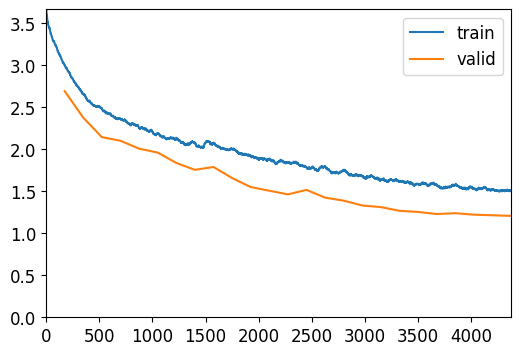

Better model found at epoch 1 with valid_loss value: 2.3734822273254395.
Better model found at epoch 2 with valid_loss value: 2.1421499252319336.
Better model found at epoch 3 with valid_loss value: 2.099591016769409.
Better model found at epoch 4 with valid_loss value: 2.005577325820923.
Better model found at epoch 5 with valid_loss value: 1.959031581878662.
Better model found at epoch 6 with valid_loss value: 1.8353418111801147.
Better model found at epoch 7 with valid_loss value: 1.753873586654663.
Better model found at epoch 9 with valid_loss value: 1.6560064554214478.
Better model found at epoch 10 with valid_loss value: 1.5487910509109497.
Better model found at epoch 11 with valid_loss value: 1.5053629875183105.
Better model found at epoch 12 with valid_loss value: 1.4615925550460815.
Better model found at epoch 14 with valid_loss value: 1.4229092597961426.
Better model found at epoch 15 with valid_loss value: 1.387086272239685.
Better model found at epoch 16 with valid_loss valu

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [ ]:
cbs=[SaveModelCallback(), ShowGraphCallback(),EarlyStoppingCallback(min_delta=0.01, patience=5)]

learn.fit_one_cycle(25, lr_max=lr[0], cbs=cbs)

Los resultados obtenidos muestran que el modelo está mejorando en comparación con el apartado anterior. La **precisión del conjunto de entrenamiento es del 57.17%**, mientras que el **conjunto de validación** ha alcanzado una **precisión superior del 62.88%**, lo que indica que el modelo está generalizando mejor y no presenta sobreajuste, ya que la precisión en validación es incluso mayor que en entrenamiento. Además, el conjunto de prueba también muestra buenos resultados con una precisión del 60.52%. Esto sugiere que, aunque el modelo ha mejorado en comparación con el anterior, todavía se pueden hacer ajustes y mejoras adicionales para optimizar aún más su rendimiento.

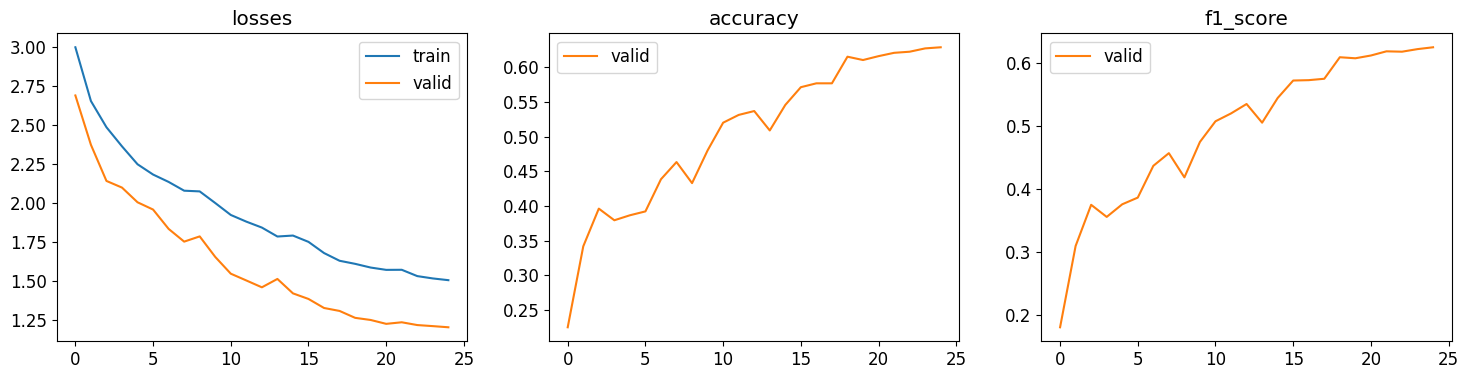

Conjunto de Entrenamiento


Número de ejemplos: 11250
Precisión: 57.17%

Conjunto de Validación


Número de ejemplos: 1250
Precisión: 62.88%

Conjunto de Prueba


Número de ejemplos: 2500
Precisión: 60.52%



In [ ]:
learn.recorder.plot_metrics()

# Obtener precisión para entrenamiento
calcular_precision(learn, learn.dls.train, "Entrenamiento")

# Obtener precisión para validación
calcular_precision(learn, learn.dls.valid, "Validación")

# Obtener precisión para prueba
test_dl = learn.dls.test_dl(files_test, with_labels=True)
calcular_precision(learn, test_dl, "Prueba")

---
---
---

## **OPTIMIZACIÓN FINAL PARA NUESTRO MODELO BASENET**

En este `DataBlock`, las transformaciones **Resize(64)** y **RandomCrop(64)** añadidas tienen un papel importante en el procesamiento de las imágenes antes de que el modelo las reciba.

El uso de **Resize(64)** ajusta todas las imágenes de 32x32 a un tamaño de 64x64 píxeles. Este aumento de tamaño no mejora la resolución de las imágenes originales, pero puede proporcionar al modelo más espacio para identificar detalles más complejos. Sin embargo, este estiramiento puede introducir información artificial o "ruido" que no estaba presente en la imagen original. Aunque el objetivo es facilitar la detección de patrones más finos, como en todo siempre existe  riesgos, en este caso de que la imagen estirada no aporte mejoras significativas y pueda afectar el rendimiento del modelo.

Por otro lado, **RandomCrop(64)** realiza un recorte aleatorio de 64x64 píxeles en cada imagen. Aumentando la variabilidad del conjunto de datos de entrenamiento, y de esta forma el modelo no se centrará siempre en las mismas partes de la imagen, sino que aprenderá a reconocer patrones en diferentes regiones. Al aplicar este tipo de recorte aleatorio, el modelo mejora su capacidad para generalizar y evitar el sobreajuste, ya que se ve forzado a aprender representaciones más flexibles de los datos.

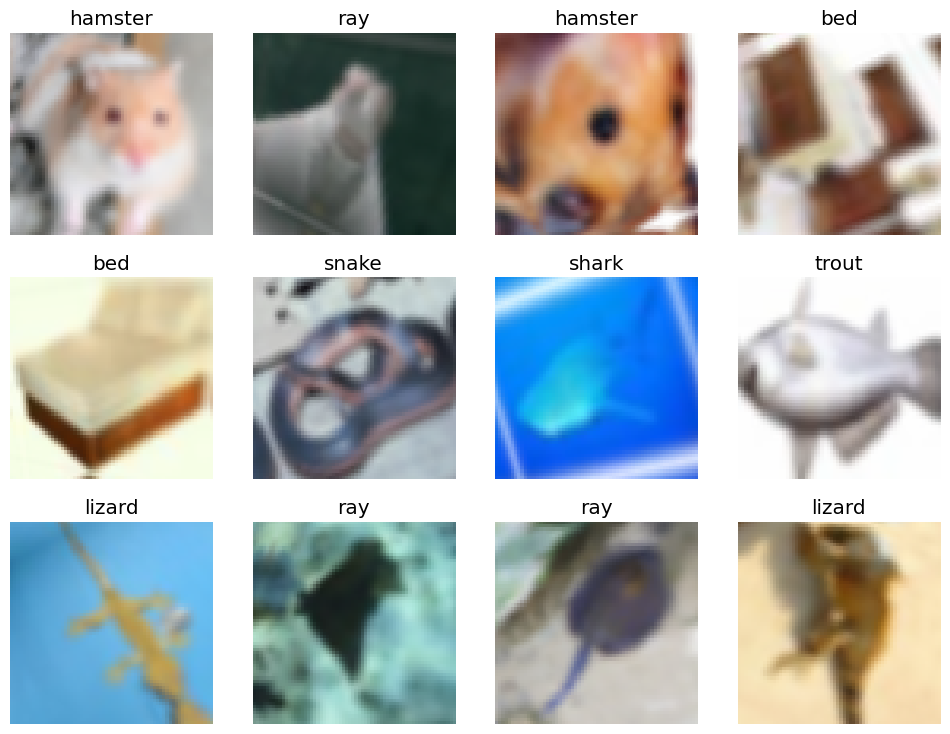

In [ ]:
# Definir el DataBlock con Normalizacion,Aug_trasnform, Resize y RandomCrop
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # 10% validación
    get_y=parent_label,
    item_tfms=[Resize(64)],
    batch_tfms=[
        *aug_transforms(
            flip_vert=True,
            max_rotate=30.0,
            max_zoom=1.1,
            max_lighting=0.2,
            p_affine=0.75,
            p_lighting=0.75
        ),
        RandomCrop(64),
        Normalize.from_stats(*imagenet_stats)
    ]
)

# Crear los DataLoaders
dls = data_block.dataloaders(path/'train')
dls.show_batch(max_n=12)

En este nuevo modelo, se ha añadido un **tercer bloque convolucional**, lo que sigue el mismo enfoque que el modelo anterior, pero con una mayor profundidad. Al igual que antes, los bloques convolucionales están formados por dos capas convolucionales seguidas de normalización y activación ReLU, lo que permite al modelo aprender representaciones más complejas. Además, se ha añadido la activación ReLU en la última capa de cada bloque, ya que en el modelo anterior se omitió en la última capa del último bloque, lo que podría haber afectado negativamente los resultados.

Al agregar esta activación, se espera que el modelo pueda aprender representaciones más complejas y no lineales, mejorando su capacidad de aprendizaje y evitando posibles problemas de entrenamiento relacionados con la falta de activación. Sin embargo, el incremento de complejidad también puede generar sobreajuste, así que mas abajo veremos sus resultados.

In [ ]:
def Conv_block(in_channels, out_channels):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(),
    nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
    nn.BatchNorm2d(out_channels),
    nn.ReLU()
  )

BaseNet_final = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2),# Reduce de 64x64 a 32x32

    # 1º Bloque convolucional
    Conv_block(16, 32),
    nn.MaxPool2d(2),  # Reduce de 32x32 a 16x16

    # 2º Bloque convolucional
    Conv_block(32, 64),
    nn.MaxPool2d(2),  # Reduce de 16x16 a 8x8

    # 3º Bloque convolucional
    Conv_block(64, 128),
    nn.MaxPool2d(2), # Reduce de 8x8 a 4x4

    nn.Flatten(),

    nn.Linear(128*4*4, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),

    nn.Linear(256, 25)
)

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

0.0003981071640737355


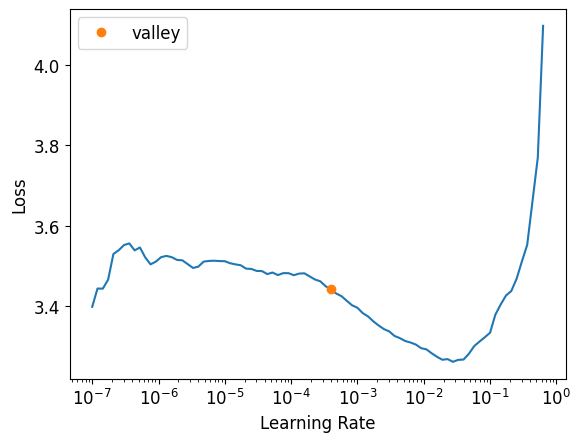

In [ ]:
Adam_opt = partial(OptimWrapper, opt=optim.Adam) # OptimWrapper class wraps Pytorch optimizer for training

learn = Learner(
    dls,
    BaseNet_final,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, F1Score(average='weighted')],
    opt_func=Adam_opt,
)

# Buscar la tasa de aprendizaje
lr = learn.lr_find()
print(lr[0])

De nuevo, el resumen de la arquitectura coincide con lo esperado. En este caso, el modelo tiene un tamaño de lote de 64, con imágenes de 3 canales RGB y un tamaño de 64x64 píxeles. Al añadir un tercer bloque convolucional, las dimensiones de las imágenes se reducen progresivamente debido a la aplicación de MaxPooling en cada bloque, lo que resulta en una reducción de las dimensiones espaciales (de 64x64 a 32x32, luego a 16x16, posteriormente a 8x8 y finalmente a 4x4 antes de llegar a la capa de `Flatten`). Como resultado, se obtiene un tensor con un tamaño de 2048 características (64 * 4 * 4) antes de ser pasado a la capa lineal. Esta modificación, aunque reduce los parámetros, sigue permitiendo que el modelo capture características complejas a través de las capas convolucionales antes de hacer el *flattening* y pasadas a las capas completamente conectadas. Esto puede ayudar a mejorar la generalización sin sobrecargar la red con demasiados parámetros, como ocurrió en el modelo anterior.

In [ ]:
learn.summary()

Sequential (Input shape: 64 x 3 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 16 x 64 x 64   
Conv2d                                    448        True      
ReLU                                                           
BatchNorm2d                               32         True      
____________________________________________________________________________
                     64 x 16 x 32 x 32   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 32 x 32 x 32   
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9248       True      
BatchNorm2d                               64         True      
ReLU                                 

Entrenamos esta vez por 50 épocas, dando mas tiempo para mejorar.

Better model found at epoch 0 with valid_loss value: 2.7164523601531982.


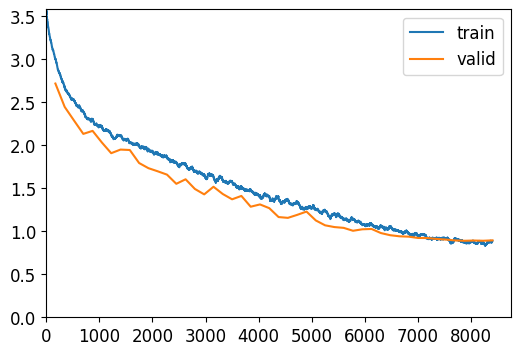

Better model found at epoch 1 with valid_loss value: 2.444598913192749.
Better model found at epoch 2 with valid_loss value: 2.2868587970733643.
Better model found at epoch 3 with valid_loss value: 2.1313438415527344.
Better model found at epoch 5 with valid_loss value: 2.0308237075805664.
Better model found at epoch 6 with valid_loss value: 1.9069310426712036.
Better model found at epoch 9 with valid_loss value: 1.792763113975525.
Better model found at epoch 10 with valid_loss value: 1.7329946756362915.
Better model found at epoch 11 with valid_loss value: 1.6965669393539429.
Better model found at epoch 12 with valid_loss value: 1.6577775478363037.
Better model found at epoch 13 with valid_loss value: 1.5511069297790527.
Better model found at epoch 15 with valid_loss value: 1.4912430047988892.
Better model found at epoch 16 with valid_loss value: 1.4284266233444214.
Better model found at epoch 19 with valid_loss value: 1.370974063873291.
Better model found at epoch 21 with valid_loss 

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [ ]:
cbs=[SaveModelCallback(), ShowGraphCallback(),EarlyStoppingCallback(min_delta=0.01, patience=5)]

learn.fit_one_cycle(50, lr_max=lr[0], cbs=cbs)

Los resultados obtenidos son bastante buenos, ya que el modelo alcanza una precisión de **75.96% en el conjunto de entrenamiento**, lo que indica un buen desempeño en la tarea de clasificación. Sin embargo, en el **conjunto de validación, la precisión es de 71.84%**, y en el **conjunto de prueba, 72.40%**, lo que refleja una ligera diferencia en comparación con el entrenamiento. Esta diferencia podría sugerir una ligera tendencia al sobreajuste, especialmente visible en las últimas etapas del entrenamiento cuando se observa que el modelo sigue mejorando en el conjunto de entrenamiento pero no en la validación. A pesar de esto, el sobreajuste no es muy grande, y el modelo generaliza bastante bien a nuevos datos. Esto sugiere que, aunque se podría optimizar un poco más, los resultados son excelentes en términos generales.

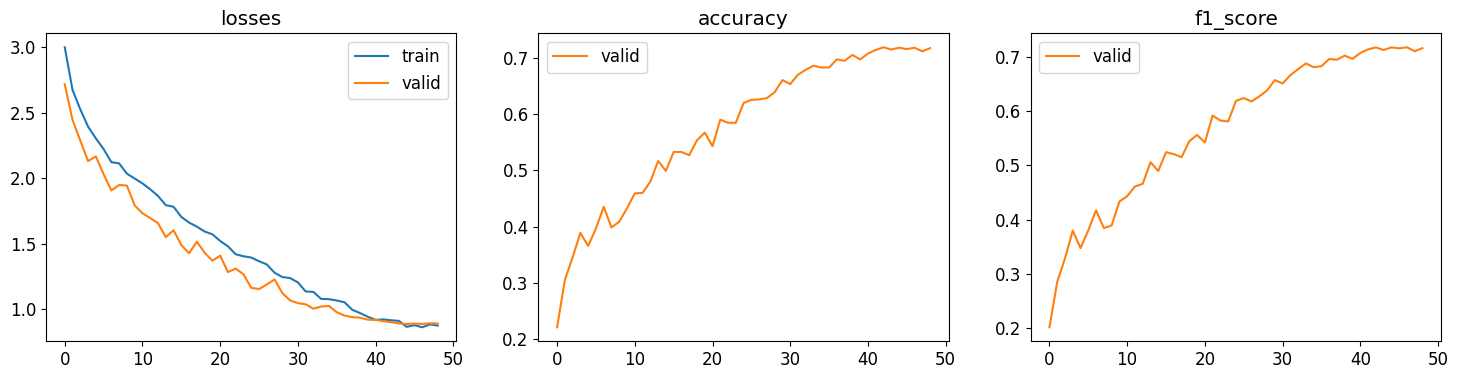

Conjunto de Entrenamiento


Número de ejemplos: 11250
Precisión: 75.96%

Conjunto de Validación


Número de ejemplos: 1250
Precisión: 71.84%

Conjunto de Prueba


Número de ejemplos: 2500
Precisión: 72.40%



In [ ]:
learn.recorder.plot_metrics()

# Obtener precisión para entrenamiento
calcular_precision(learn, learn.dls.train, "Entrenamiento")

# Obtener precisión para validación
calcular_precision(learn, learn.dls.valid, "Validación")

# Obtener precisión para prueba
test_dl = learn.dls.test_dl(files_test, with_labels=True)
calcular_precision(learn, test_dl, "Prueba")

Conjunto de Entrenamiento


Número de ejemplos: 11250
Precisión:  76.57777777777778


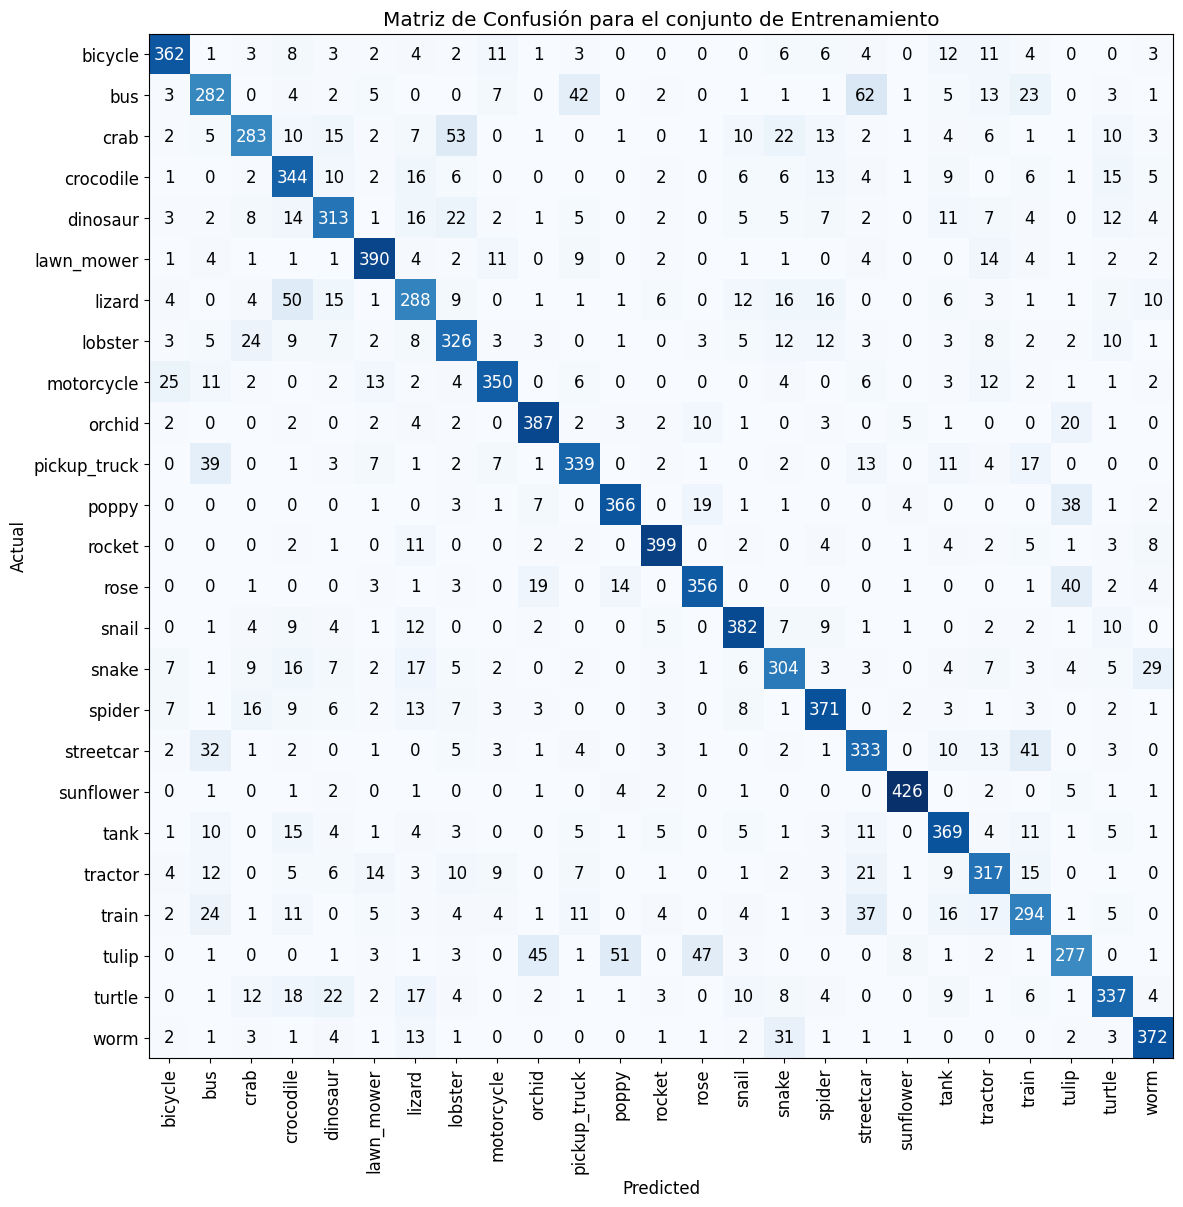

In [ ]:
# Precisión en el conjunto de entrenamiento
train_dl = learn.dls.train
interp_train = print_accuracy_and_matrix(train_dl, "Entrenamiento")

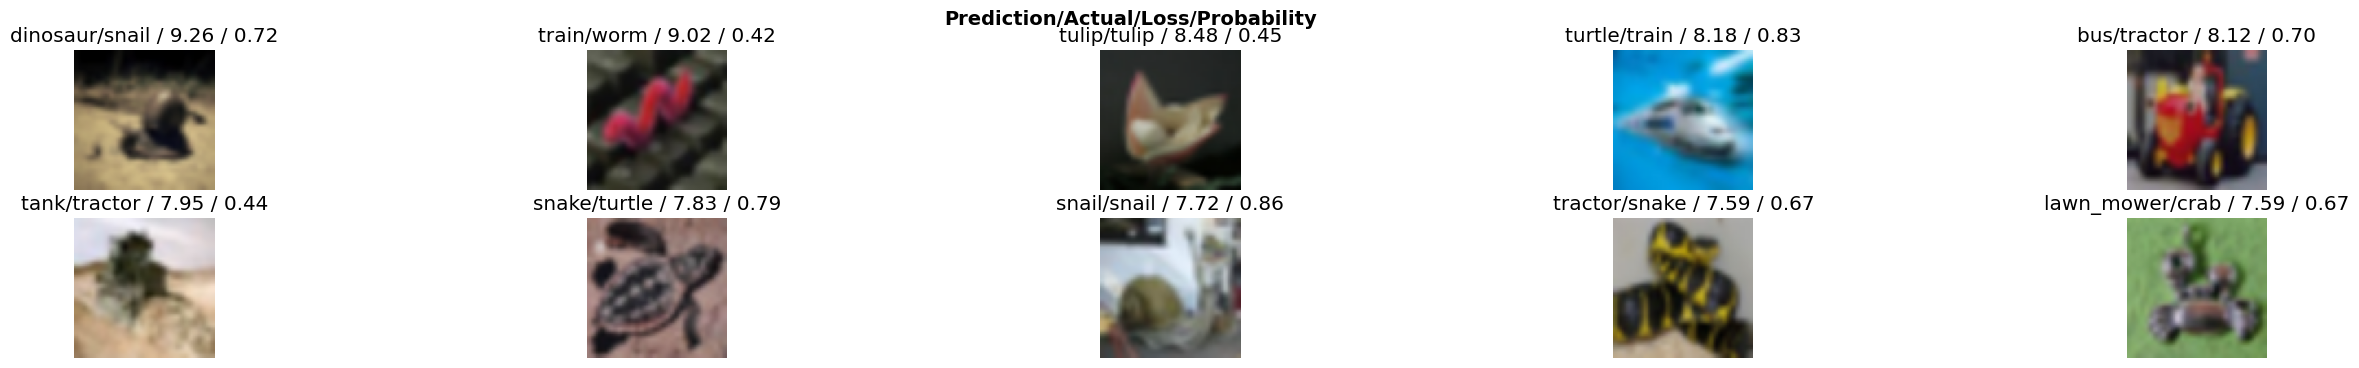

In [ ]:
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

Conjunto de Validación


Número de ejemplos: 1250
Precisión:  71.84


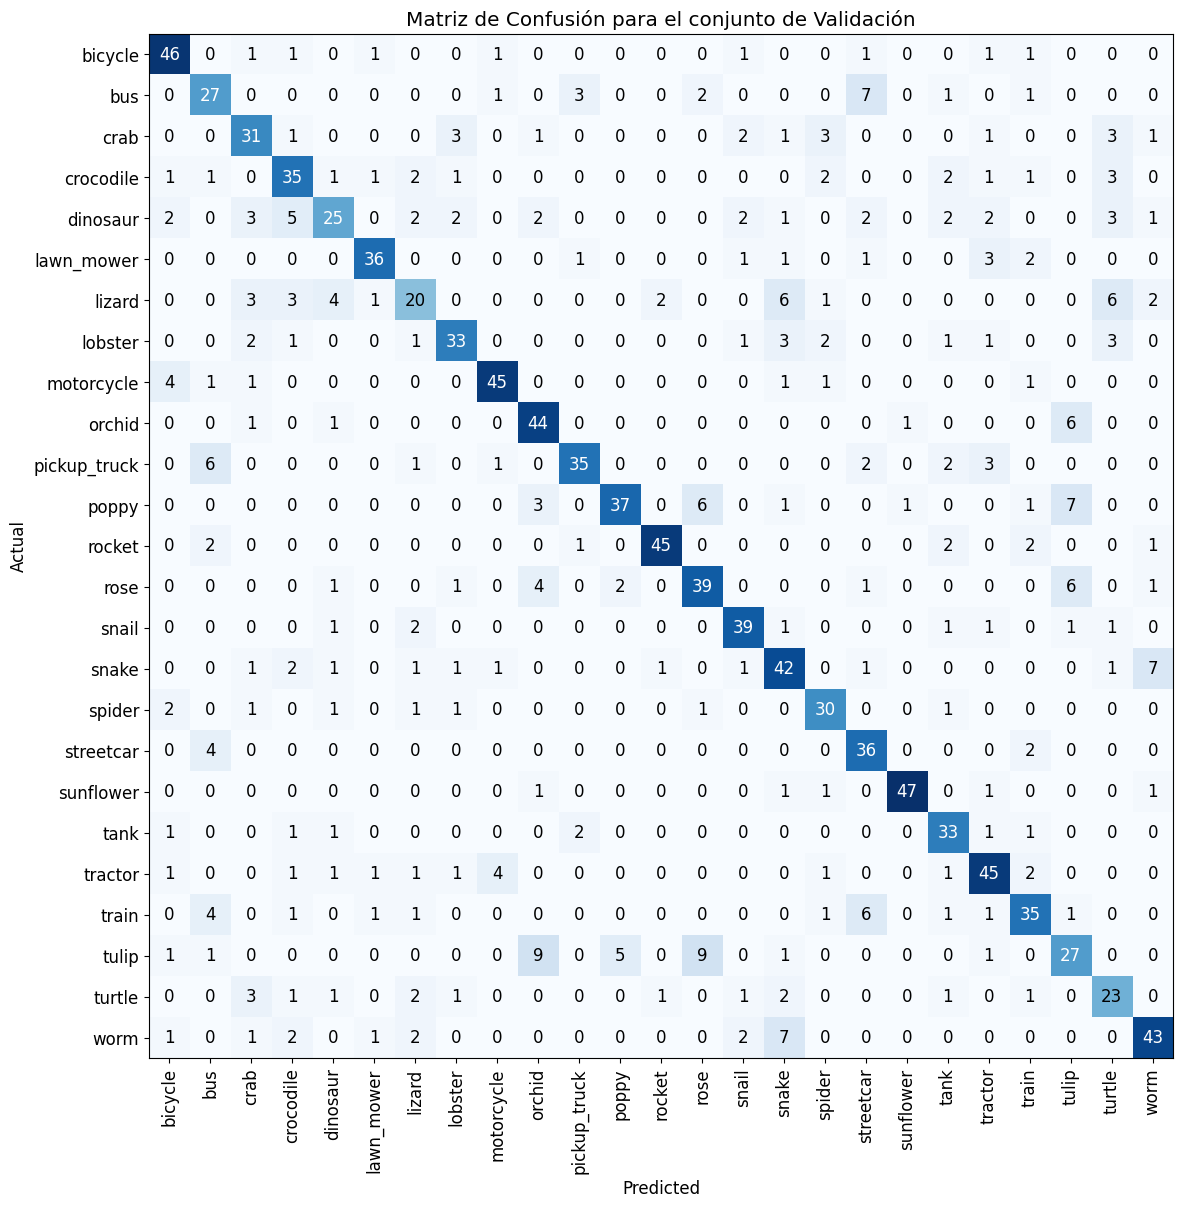

In [ ]:
# Precisión en el conjunto de validación
valid_dl = learn.dls.valid
interp_valid = print_accuracy_and_matrix(valid_dl, "Validación")

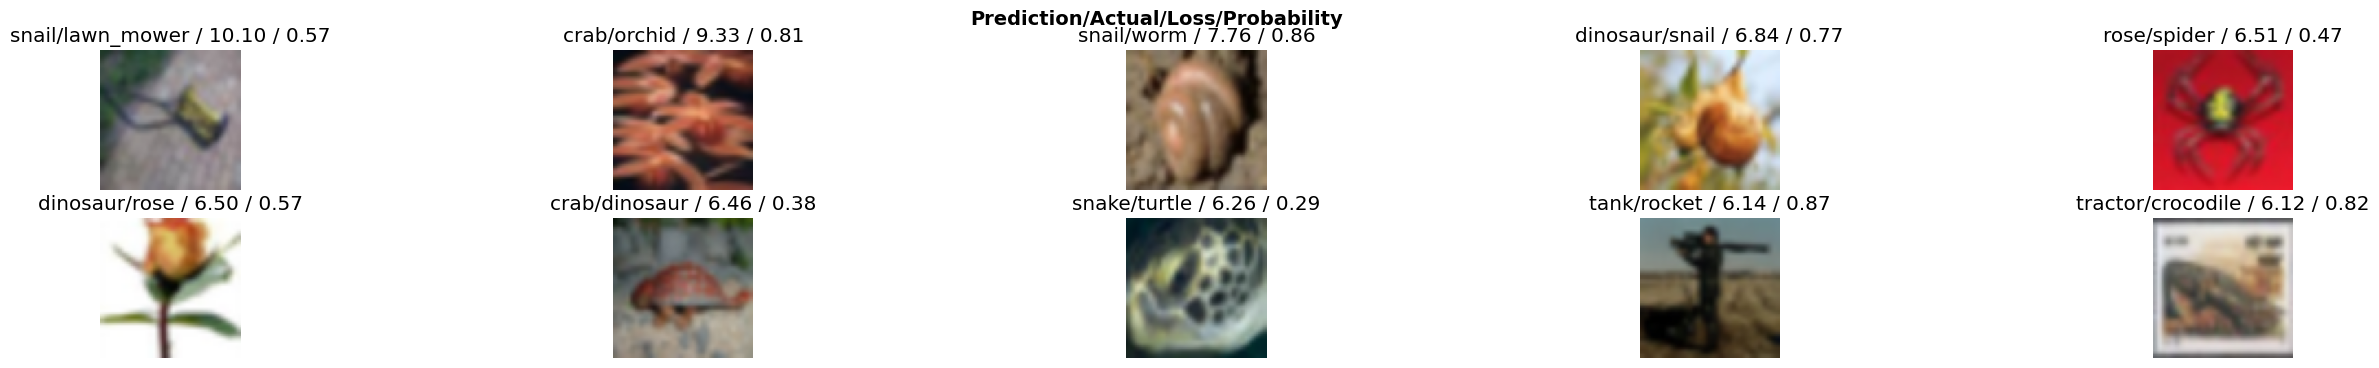

In [ ]:
interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))

Conjunto de Prueba


Número de ejemplos: 2500
Precisión:  72.39999999999999


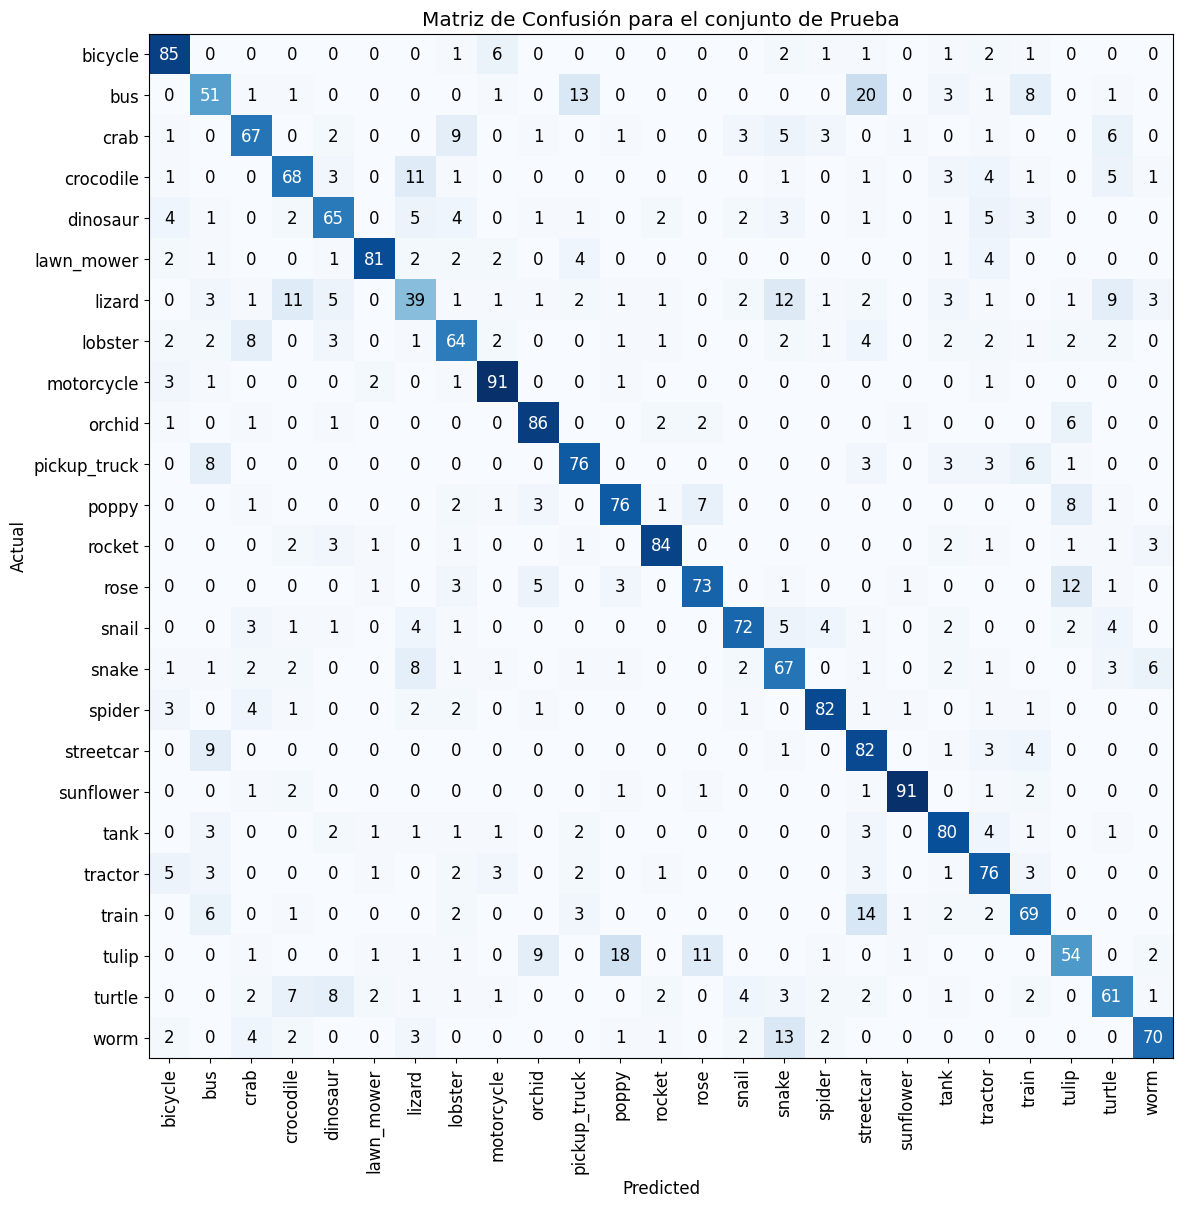

In [ ]:
# Precisión en el conjunto de prueba
test_dl = learn.dls.test_dl(files_test, with_labels=True)
interp_test = print_accuracy_and_matrix(test_dl, "Prueba")

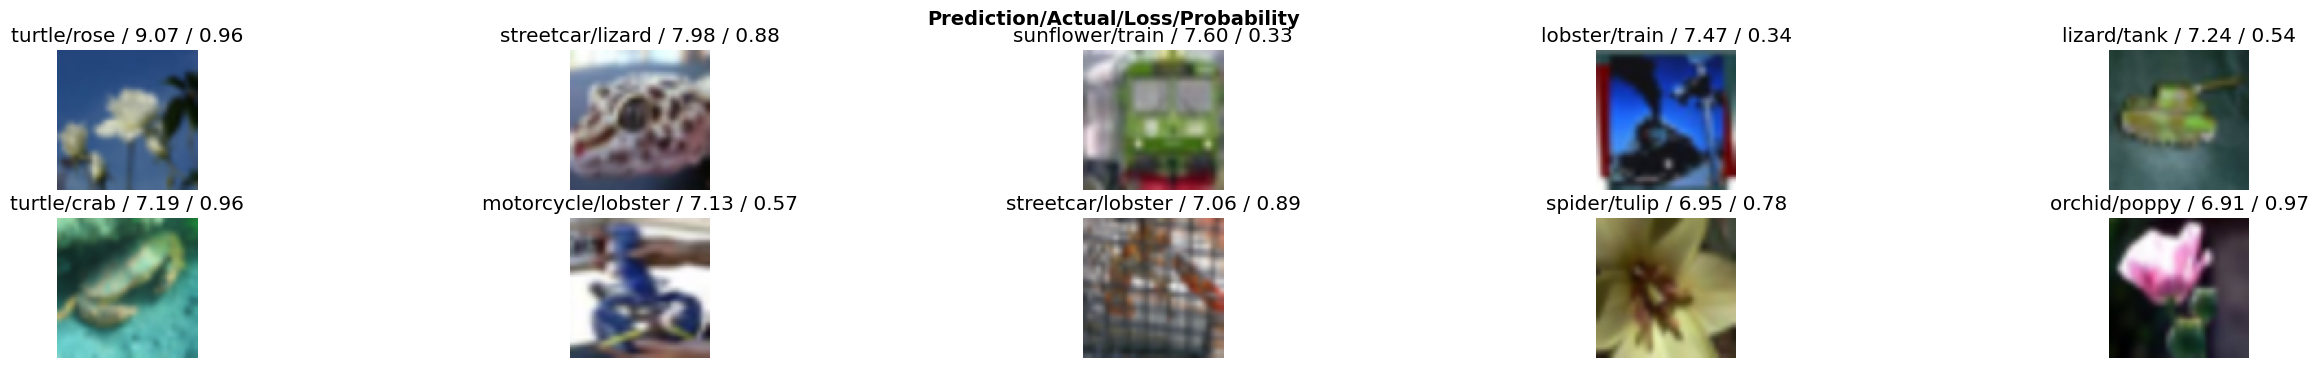

In [ ]:
interp_test.plot_top_losses(10, nrows=2, figsize=(32,4))